## Generate client_data_mapping

OG total clients: 25366, total images: 1482549
After filtering >= 32: 9824 clients, total images=1361779, min=32, max=6760
empirical_boot   KL(emp||model)=0.000009   Wasserstein=0.238584
lognormal_mle    KL(emp||model)=0.099994   Wasserstein=32.937279
lognorm_scipy    KL(emp||model)=0.010725   Wasserstein=8.080799
gmm2             KL(emp||model)=0.044327   Wasserstein=14.460483
pareto_tail      KL(emp||model)=0.016030   Wasserstein=16.079212

Best by KL: empirical_boot
Best by Wasserstein: empirical_boot

--- Model parameters ---
empirical_boot: B_BOOT = 300  (averaged binned pmass available in JSON)
lognormal_mle: mu=4.487176, sigma=0.809008   (fit on log(counts))
lognorm_scipy: shape=1.444585, loc=30.883324, scale=40.740193
gmm2 components:
  comp0: weight=0.361727, mean_log=5.255194, std_log=0.775601
  comp1: weight=0.638273, mean_log=4.051920, std_log=0.400955
pareto_tail: xmin=273.000000, alpha_hat=2.648509 (fitted on tail, percentile=90)


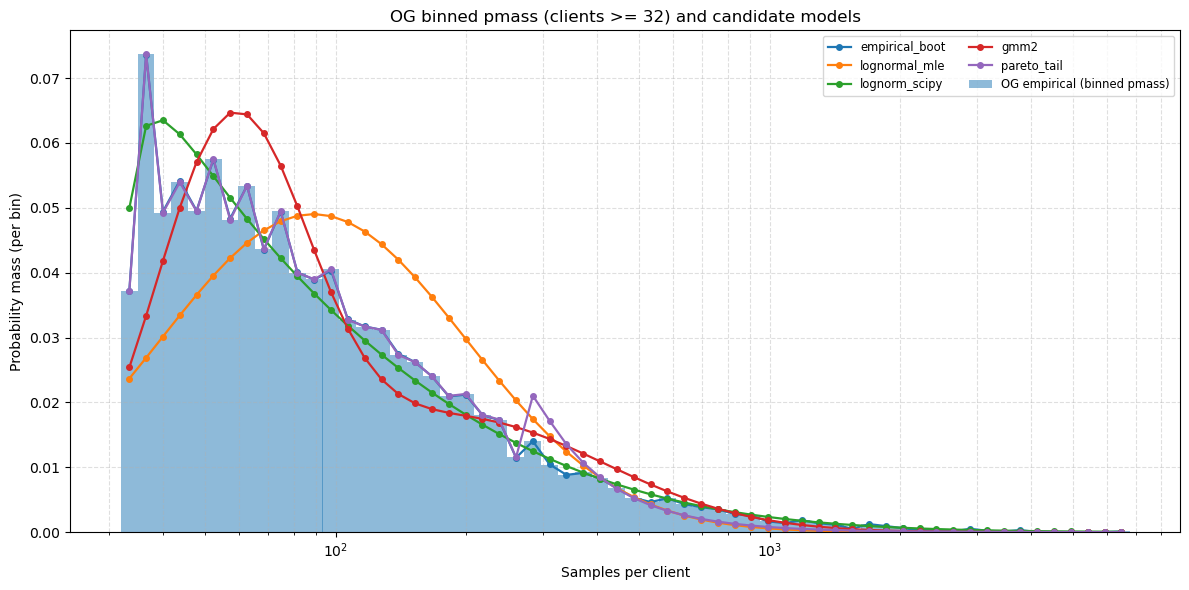

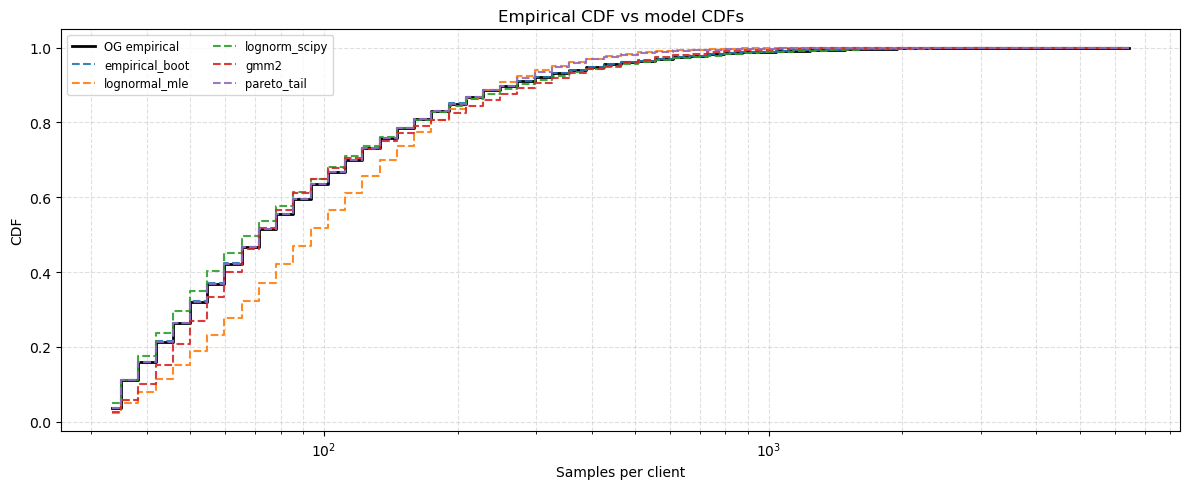

In [39]:
# Fit-comparison + parameter dump (clients with >=32 samples)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict
from sklearn.mixture import GaussianMixture
from scipy.stats import lognorm as scipy_lognorm, norm
import json, warnings
warnings.filterwarnings("ignore")

# -----------------------
# Config
# -----------------------
MAPPING_DIR_OG = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping_og")
CSV_FILES = [
    MAPPING_DIR_OG / "train.csv",
    MAPPING_DIR_OG / "validation.csv",
    MAPPING_DIR_OG / "test.csv",
]
RNG_SEED = 42
np.random.seed(RNG_SEED)

# Empirical bootstrap settings
B_BOOT = 300           # bootstrap reps for empirical pmass estimate
PCT_XMIN = 90          # percentile for Pareto tail modeling
N_BINS = 60            # number of log-spaced bins
MIN_SAMPLES = 32       # clients with counts < MIN_SAMPLES are removed

# -----------------------
# Load counts
# -----------------------
dfs = []
for p in CSV_FILES:
    if not p.exists():
        raise FileNotFoundError(f"{p} not found: {p}")
    dfs.append(pd.read_csv(p, usecols=["client_id"]))
df = pd.concat(dfs, ignore_index=True)
counts_per_client_all = df.groupby("client_id").size().astype(int).values
print(f"OG total clients: {len(counts_per_client_all)}, total images: {counts_per_client_all.sum()}")

# Filter clients with at least MIN_SAMPLES samples (as requested)
counts_per_client = counts_per_client_all[counts_per_client_all >= MIN_SAMPLES]
C_orig = len(counts_per_client)
total_images_filtered = int(counts_per_client.sum())
if C_orig == 0:
    raise RuntimeError(f"No clients with >= {MIN_SAMPLES} samples found.")
print(f"After filtering >= {MIN_SAMPLES}: {C_orig} clients, total images={total_images_filtered}, min={counts_per_client.min()}, max={counts_per_client.max()}")

# -----------------------
# Bins (log-spaced)
# -----------------------
xmin = float(max(1, counts_per_client.min()))
xmax = float(counts_per_client.max())
bin_edges = np.logspace(np.log10(xmin), np.log10(xmax), N_BINS + 1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
hist_emp, _ = np.histogram(counts_per_client, bins=bin_edges, density=False)
p_emp = hist_emp.astype(float) / hist_emp.sum()

# -----------------------
# helper metrics
# -----------------------
def binned_kl(p, q, eps=1e-12):
    p = np.asarray(p, dtype=float) + eps
    q = np.asarray(q, dtype=float) + eps
    p = p / p.sum()
    q = q / q.sum()
    return float(np.sum(p * (np.log(p) - np.log(q))))

def binned_wasserstein(p, q, locations, edges=bin_edges):
    p = np.asarray(p, dtype=float) / (np.sum(p) + 1e-12)
    q = np.asarray(q, dtype=float) / (np.sum(q) + 1e-12)
    cdf_p = np.cumsum(p)
    cdf_q = np.cumsum(q)
    # approximate integral |CDF_p - CDF_q| dx using bin edges
    deltas = np.diff(edges)  # widths of bins
    return float(np.sum(np.abs(cdf_p - cdf_q) * deltas))

# -----------------------
# 1) Empirical bootstrap average pmass (non-parametric)
# -----------------------
def empirical_bootstrap_avg_pmass(original_counts, n_boot=B_BOOT, bins=bin_edges):
    acc = np.zeros(len(bins) - 1, dtype=float)
    for _ in range(n_boot):
        sample = np.random.choice(original_counts, size=original_counts.size, replace=True)
        hist, _ = np.histogram(sample, bins=bins, density=False)
        acc += hist
    acc = acc / acc.sum()
    return acc

p_emp_boot = empirical_bootstrap_avg_pmass(counts_per_client, n_boot=B_BOOT, bins=bin_edges)

# -----------------------
# 2) Single lognormal (MLE on log counts) -> params mu, sigma
# -----------------------
logx = np.log(counts_per_client)
mu_hat = float(logx.mean())
sigma_hat = float(logx.std(ddof=0))
from scipy.stats import lognorm as scipy_lognorm
ln_model = scipy_lognorm(s=sigma_hat, scale=np.exp(mu_hat))
pmass_lognormal_mle = ln_model.cdf(bin_edges[1:]) - ln_model.cdf(bin_edges[:-1])
pmass_lognormal_mle = np.maximum(pmass_lognormal_mle, 0.0)
pmass_lognormal_mle /= (pmass_lognormal_mle.sum() + 1e-12)

# -----------------------
# 3) SciPy lognorm fit (shape, loc, scale)
# -----------------------
try:
    shape_s, loc_s, scale_s = scipy_lognorm.fit(counts_per_client)
    ln_scipy = scipy_lognorm(s=shape_s, loc=loc_s, scale=scale_s)
    pmass_lognorm_scipy = ln_scipy.cdf(bin_edges[1:]) - ln_scipy.cdf(bin_edges[:-1])
    pmass_lognorm_scipy = np.maximum(pmass_lognorm_scipy, 0.0)
    pmass_lognorm_scipy /= (pmass_lognorm_scipy.sum() + 1e-12)
except Exception as e:
    shape_s, loc_s, scale_s = (None, None, None)
    pmass_lognorm_scipy = np.zeros_like(pmass_lognormal_mle)
    print("SciPy lognorm fit failed:", e)

# -----------------------
# 4) 2-component GMM on log-counts -> mixture of lognormals
# -----------------------
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=RNG_SEED)
gmm.fit(logx.reshape(-1,1))
weights = gmm.weights_.tolist()
means = gmm.means_.ravel().tolist()
vars_ = gmm.covariances_.ravel().tolist()
stds = [float(np.sqrt(v)) for v in vars_]
pmass_gmm2 = np.zeros(len(bin_centers), dtype=float)
for k, (wk, mu_k, var_k) in enumerate(zip(weights, means, vars_)):
    sigma_k = np.sqrt(var_k)
    cdf_vals = norm.cdf((np.log(bin_edges) - mu_k) / sigma_k)
    bin_masses_k = cdf_vals[1:] - cdf_vals[:-1]
    pmass_gmm2 += wk * bin_masses_k
pmass_gmm2 = np.maximum(pmass_gmm2, 0.0)
pmass_gmm2 /= (pmass_gmm2.sum() + 1e-12)

# -----------------------
# 5) Pareto tail (hybrid: empirical below xmin, Pareto above)
# -----------------------
xmin = float(np.percentile(counts_per_client, PCT_XMIN))
tail = counts_per_client[counts_per_client >= xmin]
n_tail = len(tail)
if n_tail > 0 and xmin > 0:
    alpha_hat = float(1.0 + n_tail / np.sum(np.log(tail / xmin)))
else:
    alpha_hat = None

pmass_pareto = np.zeros(len(bin_centers), dtype=float)
emp_mask_bins_below = bin_edges[1:] < xmin
pmass_pareto[emp_mask_bins_below] = p_emp[emp_mask_bins_below]
if n_tail > 0:
    def pareto_cdf(x):
        x = np.array(x, dtype=float)
        out = np.zeros_like(x, dtype=float)
        idx = x >= xmin
        out[idx] = 1.0 - (xmin / x[idx]) ** alpha_hat
        return out
    for i in range(len(bin_centers)):
        a = bin_edges[i]; b = bin_edges[i+1]
        if b >= xmin:
            aa = max(a, xmin)
            pmass_pareto[i] = max(0.0, pareto_cdf(b) - pareto_cdf(aa))
    model_tail_mass = pmass_pareto[~emp_mask_bins_below].sum()
    empirical_tail_mass = p_emp[~emp_mask_bins_below].sum()
    if model_tail_mass > 0:
        pmass_pareto[~emp_mask_bins_below] *= (empirical_tail_mass / model_tail_mass)
pmass_pareto = np.maximum(pmass_pareto, 0.0)
pmass_pareto /= (pmass_pareto.sum() + 1e-12)

# -----------------------
# Collect models & compute metrics
# -----------------------
models = OrderedDict([
    ("empirical_boot", p_emp_boot),
    ("lognormal_mle", pmass_lognormal_mle),
    ("lognorm_scipy", pmass_lognorm_scipy),
    ("gmm2", pmass_gmm2),
    ("pareto_tail", pmass_pareto),
])

metrics = {}
for name, pm in models.items():
    kl = binned_kl(p_emp, pm)
    wd = binned_wasserstein(p_emp, pm, bin_centers)
    metrics[name] = {"kl": kl, "wasserstein": wd}
    print(f"{name:15s}  KL(emp||model)={kl:.6f}   Wasserstein={wd:.6f}")

best_by_kl = min(metrics.items(), key=lambda kv: kv[1]["kl"])[0]
best_by_wd = min(metrics.items(), key=lambda kv: kv[1]["wasserstein"])[0]
print("\nBest by KL:", best_by_kl)
print("Best by Wasserstein:", best_by_wd)

# -----------------------
# Print model parameters (human readable)
# -----------------------
print("\n--- Model parameters ---")
print("empirical_boot: B_BOOT =", B_BOOT, " (averaged binned pmass available in JSON)")
print(f"lognormal_mle: mu={mu_hat:.6f}, sigma={sigma_hat:.6f}   (fit on log(counts))")
if shape_s is not None:
    print(f"lognorm_scipy: shape={shape_s:.6f}, loc={loc_s:.6f}, scale={scale_s:.6f}")
else:
    print("lognorm_scipy: fit failed")
print("gmm2 components:")
for i, (w,m,s) in enumerate(zip(weights, means, stds)):
    print(f"  comp{i}: weight={w:.6f}, mean_log={m:.6f}, std_log={s:.6f}")
if alpha_hat is not None:
    print(f"pareto_tail: xmin={xmin:.6f}, alpha_hat={alpha_hat:.6f} (fitted on tail, percentile={PCT_XMIN})")
else:
    print("pareto_tail: not enough tail data to fit")

# -----------------------
# Plot: empirical pmass + all model pmass overlays
# -----------------------
plt.figure(figsize=(12,6))
widths = np.diff(bin_edges)
plt.bar(bin_centers, p_emp, width=widths, align="center", alpha=0.5, label="OG empirical (binned pmass)")
colors = {"empirical_boot":"C0","lognormal_mle":"C1","lognorm_scipy":"C2","gmm2":"C3","pareto_tail":"C4"}
for name, pm in models.items():
    plt.plot(bin_centers, pm, marker='o', linestyle='-', lw=1.6, label=f"{name}", color=colors.get(name,None), markersize=4)
plt.xscale("log")
plt.xlabel("Samples per client")
plt.ylabel("Probability mass (per bin)")
plt.title(f"OG binned pmass (clients >= {MIN_SAMPLES}) and candidate models")
plt.legend(ncol=2, fontsize="small")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

# -----------------------
# Plot: empirical CDF vs all model CDFs
# -----------------------
plt.figure(figsize=(12,5))
cdf_emp = np.cumsum(p_emp)
plt.step(bin_centers, cdf_emp, where='mid', label="OG empirical", lw=2, color='k')
for name, pm in models.items():
    cdf_m = np.cumsum(pm)
    plt.step(bin_centers, cdf_m, where='mid', label=name, linestyle='--', alpha=0.9)
plt.xscale("log")
plt.xlabel("Samples per client")
plt.ylabel("CDF")
plt.title("Empirical CDF vs model CDFs")
plt.legend(ncol=2, fontsize="small")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [1]:
# -*- coding: utf-8 -*-
import os
import csv
import json
import pickle
import random
from pathlib import Path
from collections import defaultdict, OrderedDict, Counter

import numpy as np
from scipy.stats import lognorm as scipy_lognorm

# -------------------------------
# Config (edit here if needed)
# -------------------------------
DATASET_ROOT = Path("/Data/baptiste.geisenberger/Data/openImg")
SPLITS = ["train", "validation", "test"]  # folders that exist under DATASET_ROOT
OUTPUT_DIR = DATASET_ROOT / "client_data_mapping"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Paths relative to the *notebook* location
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

# Use the first N client IDs from clients.pkl (NO remapping)
N_CLIENTS = 12640

# Train floor per client, enforced per cluster on the train split
TRAIN_FLOOR = 32

# Random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# -------------------------------
# Label-skew controls (alpha sliders in [0,1])
# -------------------------------
# Interpretation:
#   ALPHA_CLUSTER_FRAC = 1.0  -> cluster label distribution == global base (identical)
#   ALPHA_CLUSTER_FRAC = 0.0  -> cluster label distribution is near one-hot (maximally different)
#   ALPHA_CLIENT_FRAC  = 1.0  -> client label distribution == its cluster distribution (identical)
#   ALPHA_CLIENT_FRAC  = 0.0  -> client distribution is one-hot (label sampled from its cluster P_k)
#
# Practical tip to get large intra-cluster JS (≈ ln 2):
#   set ALPHA_CLUSTER_FRAC high (cluster P_k ~ broad/base) and ALPHA_CLIENT_FRAC low (clients ~ one-hot).
# ALPHA_CLUSTER_FRAC = 0.6
# ALPHA_CLIENT_FRAC  = 0.25
ALPHA_CLUSTER_FRAC = 0.85
ALPHA_CLIENT_FRAC  = 0.75

# We still allow a Dirichlet mode between the extremes.
# Map slider to Dirichlet TOTAL concentration via a more 'aggressive' geometric scale.
# Very small per-label min drives near one-hot; large max yields very smooth around base.
ALPHA_PER_LABEL_MIN = 1e-6    # extremely spiky at the low end
ALPHA_PER_LABEL_MAX = 50.0    # very smooth at the high end (per-label); total = per-label * L

# -------------------------------
# Cluster size skew by rank
# -------------------------------
# Order clusters by ASCENDING "rank" (rank=1 highest priority). Assign decreasing per-client averages:
#   s_k = 1 - GAMMA * (pos / (K-1)), where pos=0 for rank=1 cluster.
# Larger GAMMA -> steeper drop from highest-rank to lowest-rank cluster.
GAMMA_CLUSTER_LINEAR = 0.3

# Per-client size law (same in every cluster): lognormal from OG fit (clients >=32)
LOGNORM_SHAPE = 1.444585   # scipy 's' (sigma)
LOGNORM_LOC   = 30.883324  # scipy 'loc' (shift)
LOGNORM_SCALE = 40.740193  # scipy 'scale' (exp(mu) if loc==0)


# File extension filter
EXTENSIONS = {".jpg", ".jpeg", ".JPG", ".JPEG"}

# -------------------------------
# Helpers
# -------------------------------

def extract_label_from_filename(fname: str) -> str:
    base = os.path.basename(fname)
    stem, _ = os.path.splitext(base)
    if "___" not in stem:
        raise ValueError(f"Filename does not contain '___': {fname}")
    after = stem.split("___", 1)[1]
    return after if after.startswith("_") else "_" + after

def list_images_by_split(dataset_root: Path, splits):
    result = {}
    for split in splits:
        split_dir = dataset_root / split
        if not split_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {split_dir}")
        files = []
        for p in split_dir.iterdir():
            if p.is_file() and p.suffix in EXTENSIONS:
                rel_path = p.name
                label = extract_label_from_filename(p.name)
                files.append((rel_path, label))
        if not files:
            raise RuntimeError(f"No images found in {split_dir} with extensions {EXTENSIONS}")
        result[split] = files
    return result

def load_clusters_and_clients(clusters_json_path: Path, clients_pkl_path: Path, n_clients: int):
    with open(clusters_json_path, "r") as f:
        clusters = json.load(f)

    # Build (cluster_id -> rank) and model->cluster_id maps
    cluster_rank = {}
    model_to_cluster = {}
    for c in clusters:
        cid = int(c["id"])
        cluster_rank[cid] = float(c.get("rank", 0))
        for m in c.get("models", []):
            if m in model_to_cluster and model_to_cluster[m] != cid:
                raise ValueError(f"Model '{m}' appears in multiple clusters ({model_to_cluster[m]} and {cid})")
            model_to_cluster[m] = cid

    with open(clients_pkl_path, "rb") as f:
        clients_obj = pickle.load(f)

    entries = []
    if isinstance(clients_obj, (dict, OrderedDict)):
        for v in clients_obj.values():
            cid = int(v["id"]) if "id" in v else None
            if cid is None:
                raise RuntimeError("clients.pkl entry missing 'id'.")
            entries.append({"id": cid, "model": v["model"]})
    elif isinstance(clients_obj, (list, tuple)):
        for v in clients_obj:
            entries.append({"id": int(v["id"]), "model": v["model"]})
    else:
        raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")

    entries.sort(key=lambda x: x["id"])
    if len(entries) < n_clients:
        raise ValueError(f"Requested {n_clients} clients but clients.pkl has only {len(entries)}")

    selected = entries[:n_clients]
    client_ids = [e["id"] for e in selected]

    # Map clients -> clusters
    missing = []
    client2cluster = {}
    cluster2clients = defaultdict(list)
    for e in selected:
        cid = e["id"]
        model = e["model"]
        if model not in model_to_cluster:
            missing.append((cid, model))
        else:
            k = model_to_cluster[model]
            client2cluster[cid] = k
            cluster2clients[k].append(cid)

    if missing:
        sample = "\n".join([f"  client_id={cid} model='{m}'" for cid, m in missing[:20]])
        more = "" if len(missing) <= 20 else f"\n  ... and {len(missing)-20} more"
        raise RuntimeError("Some selected clients have models not in clusters.json.\n" + sample + more)

    return client_ids, client2cluster, cluster2clients, cluster_rank

def build_label_vocab(split_files: dict):
    labels = set()
    for split, files in split_files.items():
        for _, label in files:
            labels.add(label)
    label_list = sorted(labels)
    label_to_id = {lbl: i for i, lbl in enumerate(label_list)}
    id_to_label = {i: lbl for lbl, i in label_to_id.items()}

    pools = {}
    for split, files in split_files.items():
        lab2paths = defaultdict(list)
        for rel_path, label in files:
            lab2paths[label].append(rel_path)
        for lab in lab2paths:
            random.shuffle(lab2paths[lab])
        pools[split] = lab2paths
    return label_to_id, id_to_label, pools

def normalize_counts_to_total(raw_sizes, total, floor=0):
    n = len(raw_sizes)
    if floor * n > total:
        raise ValueError(f"Cannot satisfy floor={floor} with n={n} and total={total}")
    remaining = total - floor * n
    w = np.array(raw_sizes, dtype=float)
    w = np.maximum(w, 0)
    if w.sum() == 0:
        w = np.ones_like(w)
    w /= w.sum()
    alloc = (w * remaining).astype(int)
    residual = remaining - int(alloc.sum())
    if residual > 0:
        fracs = (w * remaining) - np.floor(w * remaining)
        order = np.argsort(-fracs)
        for idx in order[:residual]:
            alloc[idx] += 1
    alloc += floor
    delta = total - int(alloc.sum())
    if delta != 0:
        sign = 1 if delta > 0 else -1
        for i in range(abs(delta)):
            alloc[i % n] += sign
    assert int(alloc.sum()) == total
    return alloc

def map_alpha_total(frac: float, num_labels: int) -> float:
    """Map slider in [0,1] to Dirichlet TOTAL concentration, label-aware (aggressive geometric scale)."""
    frac = float(np.clip(frac, 0.0, 1.0))
    per_label = (ALPHA_PER_LABEL_MIN ** (1.0 - frac)) * (ALPHA_PER_LABEL_MAX ** frac)
    return float(per_label * max(1, num_labels))

def sample_cluster_distribution(base_probs: np.ndarray, alpha_frac: float) -> np.ndarray:
    """Generate a cluster label distribution from slider:
       1.0 -> exactly base; 0.0 -> near one-hot random; else -> Dirichlet around base."""
    base = np.asarray(base_probs, dtype=float)
    base = base / (base.sum() + 1e-12)
    L = len(base)

    if alpha_frac >= 1.0 - 1e-12:
        return base.copy()

    if alpha_frac <= 1e-12:
        # near one-hot: symmetric tiny-conc dirichlet, then tiny blend with base to avoid zeros
        eps = 1e-6
        v = np.random.dirichlet(np.full(L, eps))
        v = 0.99 * v + 0.01 * base
        v /= v.sum()
        return v

    total = map_alpha_total(alpha_frac, L)
    params = np.maximum(total * base, 1e-20)
    v = np.random.dirichlet(params)
    return v

def sample_client_distribution(Pk: np.ndarray, alpha_client_frac: float) -> np.ndarray:
    """Client distribution as mixture of cluster Pk and a one-hot draw:
       beta = 1 - alpha_client_frac; q = (1-beta)*Pk + beta*one_hot(label~Pk)."""
    Pk = np.asarray(Pk, dtype=float)
    Pk = Pk / (Pk.sum() + 1e-12)
    if alpha_client_frac >= 1.0 - 1e-12:
        return Pk.copy()
    L = len(Pk)
    beta = 1.0 - float(np.clip(alpha_client_frac, 0.0, 1.0))
    # draw a label according to Pk (keeps cluster coherence)
    ell = int(np.random.choice(L, p=Pk))
    one = np.zeros(L, dtype=float); one[ell] = 1.0
    q = (1.0 - beta) * Pk + beta * one
    q = np.maximum(q, 1e-12)
    q /= q.sum()
    return q

# -------------------------------
# Main
# -------------------------------

# 1) Load clients/clusters and build mappings (NO ID remapping)
client_ids, client2cluster, cluster2clients, cluster_rank = load_clusters_and_clients(
    CLUSTERS_JSON, CLIENTS_PKL, N_CLIENTS
)
client_ids = sorted(client_ids)  # deterministic order

# 2) Scan dataset & build label vocabulary and pools
split_files = list_images_by_split(DATASET_ROOT, SPLITS)
label_to_id, id_to_label, split_label_pools = build_label_vocab(split_files)
L = len(label_to_id)

# Global hist per split + combined base
global_hist = {}
for split in SPLITS:
    cnt = Counter(lbl for _, lbl in split_files[split])
    vec = np.zeros(L, dtype=float)
    for lbl, c in cnt.items():
        vec[label_to_id[lbl]] = c
    global_hist[split] = vec

global_total_by_split = {s: int(v.sum()) for s, v in global_hist.items()}
combined_vec = sum(global_hist.values())
combined_total = int(combined_vec.sum())
combined_base = combined_vec / (combined_vec.sum() + 1e-12)

# 3) Compute cluster ordering by rank (ASC), linear per-client averages, and quotas
clusters_present = sorted(cluster2clients.keys())
K = len(clusters_present)

# Order clusters by ASCENDING rank (rank=1 gets pos=0 -> most data per client)
ordered_clusters = sorted(clusters_present, key=lambda k: (cluster_rank.get(k, 0.0), k))

# Linear schedule s_k over positions (0..K-1)
if K > 1:
    schedule = {ordered_clusters[pos]: 1.0 - GAMMA_CLUSTER_LINEAR * (pos / (K - 1)) for pos in range(K)}
else:
    schedule = {ordered_clusters[0]: 1.0}

# Per-cluster client counts and per-cluster "weight" = per-client average * n_k
n_k = {k: len(cluster2clients[k]) for k in clusters_present}
w_k = {k: schedule[k] * n_k[k] for k in clusters_present}
sum_w = sum(w_k.values())
if sum_w <= 0:
    raise RuntimeError("Sum of cluster weights is zero.")

# Proportions applied to each split total
p_k = {k: w_k[k] / sum_w for k in clusters_present}

def quota_per_split(split_total):
    raw = {k: p_k[k] * split_total for k in clusters_present}
    quotas = {k: int(np.floor(v)) for k, v in raw.items()}
    residual = split_total - sum(quotas.values())
    if residual > 0:
        fracs = sorted(((k, raw[k] - quotas[k]) for k in clusters_present), key=lambda x: -x[1])
        for i in range(residual):
            quotas[fracs[i % len(fracs)][0]] += 1
    return quotas  # sums to split_total

cluster_quota_by_split = {s: quota_per_split(global_total_by_split[s]) for s in SPLITS}

# Enforce TRAIN_FLOOR per client on train split (borrow across clusters if needed)
train_q = cluster_quota_by_split["train"].copy()
need_min = {k: TRAIN_FLOOR * n_k[k] for k in clusters_present}
deficit = {k: max(0, need_min[k] - train_q[k]) for k in clusters_present}
total_deficit = sum(deficit.values())
if total_deficit > 0:
    surplus = {k: max(0, train_q[k] - need_min[k]) for k in clusters_present}
    total_surplus = sum(surplus.values())
    if total_surplus < total_deficit:
        raise RuntimeError("Not enough surplus to satisfy train floor per client across clusters.")
    while total_deficit > 0:
        donors = [k for k in clusters_present if surplus[k] > 0]
        for dk in donors:
            if total_deficit == 0: break
            take = min(surplus[dk], max(1, total_deficit // max(1, len(donors))))
            train_q[dk] -= take
            surplus[dk] -= take
            total_deficit -= take
        receivers = [k for k in ordered_clusters if deficit[k] > 0]
        for rk in receivers:
            if total_deficit < 0: break
            can = min(deficit[rk], take if 'take' in locals() else 1)
            if can > 0:
                train_q[rk] += can
                deficit[rk] -= can
    cluster_quota_by_split["train"] = train_q

# 4) Build per-client sizes per split, within each cluster (lognormal heavy-tail)
#    Keep sizes in dicts keyed by ORIGINAL client ID
split_client_sizes = {s: {cid: 0 for cid in client_ids} for s in SPLITS}

def sample_client_sizes_lognorm(n_clients, total_images, floor,
                                shape=LOGNORM_SHAPE, loc=LOGNORM_LOC, scale=LOGNORM_SCALE):
    """Draw continuous weights from the fitted lognormal and convert to integer counts
    that (a) sum to total_images and (b) respect 'floor' per client."""
    raw = scipy_lognorm.rvs(s=shape, loc=loc, scale=scale, size=n_clients, random_state=None)
    # guard: all-positive weights
    raw = np.maximum(raw, 1e-12)
    alloc = normalize_counts_to_total(raw, total_images, floor=floor)
    return alloc


for s in SPLITS:
    quotas = cluster_quota_by_split[s]
    for k in clusters_present:
        cids = cluster2clients[k]
        quota = quotas[k]
        floor = TRAIN_FLOOR if s == "train" else 0
        if floor * len(cids) > quota:
            floor = quota // max(1, len(cids))
        alloc = sample_client_sizes_lognorm(len(cids), quota, floor=floor)
        for cid_local, size in enumerate(alloc):
            cid = cids[cid_local]
            split_client_sizes[s][cid] = int(size)

# 5) Sample cluster P_k and client q_i from combined base (ONCE), reuse across splits
cluster_P = {}
for k in clusters_present:
    cluster_P[k] = sample_cluster_distribution(combined_base, ALPHA_CLUSTER_FRAC)

client_q = {}
for cid in client_ids:
    k = client2cluster[cid]
    client_q[cid] = sample_client_distribution(cluster_P[k], ALPHA_CLIENT_FRAC)

# 6) Assignment per split using per-label balancing (respects supplies and exact client sizes)
def assign_split_balanced(split, label_pools, client_sizes_dict, client_q_map, label_to_id):
    """Allocate all labels to clients so that:
       - each client's total equals client_sizes_dict[cid]
       - per-label supply is exactly consumed
       - label l is distributed ∝ q_i[l] * remaining_size_i (with caps)
    """
    # Pools
    pools = {lab: paths[:] for lab, paths in label_pools.items()}
    remaining_per_label = {lab: len(paths) for lab, paths in pools.items()}
    total_available = sum(remaining_per_label.values())
    total_needed = sum(client_sizes_dict.values())
    if total_available != total_needed:
        raise RuntimeError(f"Total supply ({total_available}) != total need ({total_needed}) for split={split}")

    rows = []
    cids = list(client_sizes_dict.keys())
    cid_to_pos = {cid: i for i, cid in enumerate(cids)}
    remaining = np.array([client_sizes_dict[cid] for cid in cids], dtype=int)
    L = len(label_to_id)
    # labels sorted by decreasing availability (helps feasibility)
    labels_sorted = sorted(remaining_per_label.keys(), key=lambda lab: -remaining_per_label[lab])

    for lab in labels_sorted:
        supply = remaining_per_label[lab]
        if supply <= 0:
            continue
        lid = label_to_id[lab]

        # weights: q_i[l] * remaining_i for clients with remaining>0
        q_l = np.array([client_q_map[cid][lid] for cid in cids], dtype=float)
        w = q_l * remaining
        # zero-out clients with no remaining capacity
        w = np.where(remaining > 0, w, 0.0)

        # If all weights are zero (can happen numerically), fall back to remaining capacities
        if w.sum() <= 0:
            w = remaining.astype(float)

        # initial integer allocation to sum exactly 'supply'
        alloc = normalize_counts_to_total(w, total=supply, floor=0)

        # cap by remaining capacities; redistribute leftover iteratively if needed
        caps = remaining.copy()
        alloc = np.minimum(alloc, caps)
        assigned = int(alloc.sum())
        leftover = supply - assigned
        if leftover > 0:
            # redistribute only among clients with room
            room = caps - alloc
            while leftover > 0:
                mask = room > 0
                if not np.any(mask):
                    raise RuntimeError("No remaining capacity to absorb leftover allocation.")
                # weights for redistribution: prefer higher (q_l * room)
                w2 = (q_l * room) * mask
                if w2.sum() <= 0:
                    w2 = room.astype(float)
                add = normalize_counts_to_total(w2, total=leftover, floor=0)
                add = np.minimum(add, room)
                # Ensure we add at least 1 somewhere if leftover > 0
                if add.sum() == 0:
                    idxs = np.where(mask)[0]
                    take = min(leftover, len(idxs))
                    add[idxs[:take]] += 1
                alloc += add
                room = caps - alloc
                assigned = int(alloc.sum())
                leftover = supply - assigned

        # Emit rows and update capacities
        if alloc.sum() != supply:
            raise RuntimeError("Allocation bug: did not assign full supply for label {}".format(lab))

        # Pop paths per client
        for pos, take in enumerate(alloc):
            if take <= 0:
                continue
            cid = cids[pos]
            for _ in range(int(take)):
                sp = pools[lab].pop()  # draw without replacement
                rows.append([cid, sp, lab, lid])
            remaining[pos] -= int(take)

    if remaining.sum() != 0:
        raise RuntimeError(f"Client totals not matched; remaining sum={int(remaining.sum())}")

    # Stable order
    rows.sort(key=lambda r: (r[0], r[1]))
    return rows

# Perform assignments
all_rows = {}
for split in SPLITS:
    rows = assign_split_balanced(
        split=split,
        label_pools=split_label_pools[split],
        client_sizes_dict=split_client_sizes[split],
        client_q_map=client_q,
        label_to_id=label_to_id
    )
    all_rows[split] = rows
    print(f"Assigned {len(rows)} rows for split '{split}'")

# 7) Write CSVs
for split in SPLITS:
    out_csv = OUTPUT_DIR / f"{split}.csv"
    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["client_id", "sample_path", "label_name", "label_id"])
        for cid, sp, lab, lid in all_rows[split]:
            writer.writerow([cid, sp, lab, lid])
    print(f"Wrote: {out_csv}")

print("\nDone. Point your FedScale config to:")
print(f"  data_map_file: {OUTPUT_DIR / 'train.csv'}")
print("Executor will detect n_real_clients from unique client_ids in train.csv.")

Assigned 1452311 rows for split 'train'
Assigned 63063 rows for split 'validation'
Assigned 190135 rows for split 'test'
Wrote: /Data/baptiste.geisenberger/Data/openImg/client_data_mapping/train.csv
Wrote: /Data/baptiste.geisenberger/Data/openImg/client_data_mapping/validation.csv
Wrote: /Data/baptiste.geisenberger/Data/openImg/client_data_mapping/test.csv

Done. Point your FedScale config to:
  data_map_file: /Data/baptiste.geisenberger/Data/openImg/client_data_mapping/train.csv
Executor will detect n_real_clients from unique client_ids in train.csv.


## Analyse generated mapping

Total distinct clients (all): 12640, total images: 1705509
After filtering >= 1: 12640 clients, total images=1705509, min=51, max=6976


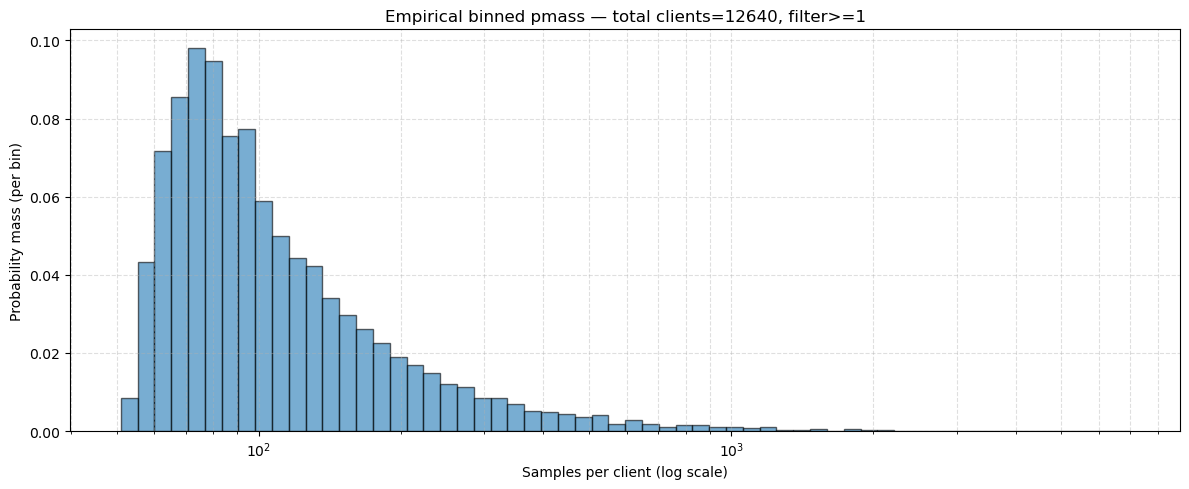

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
    "validation": MAPPING_DIR / "validation.csv",
    "test": MAPPING_DIR / "test.csv",
}
# Histogram / binning settings
N_BINS = 60          # number of log-spaced bins
MIN_SAMPLES = 1      # (optional) filter out clients with fewer than this many total samples

# -----------------------------
# Load counts (sum across splits)
# -----------------------------
dfs = []
for split, path in CSV_FILES.items():
    if not path.exists():
        raise FileNotFoundError(f"{path} not found")
    df = pd.read_csv(path, usecols=["client_id"])
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

counts_per_client_all = df_all.groupby("client_id").size().astype(int).values
print(f"Total distinct clients (all): {len(counts_per_client_all)}, total images: {counts_per_client_all.sum()}")

# Optional filtering
counts_per_client = counts_per_client_all[counts_per_client_all >= MIN_SAMPLES]
C = len(counts_per_client)
tot_images = int(counts_per_client.sum())
print(f"After filtering >= {MIN_SAMPLES}: {C} clients, total images={tot_images}, min={counts_per_client.min()}, max={counts_per_client.max()}")

# -----------------------------
# Create log-spaced bins and empirical pmass
# -----------------------------
xmin = float(max(1, counts_per_client.min()))
xmax = float(counts_per_client.max())
bin_edges = np.logspace(np.log10(xmin), np.log10(xmax), N_BINS + 1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])  # geometric mean for center
hist_emp, _ = np.histogram(counts_per_client, bins=bin_edges, density=False)
p_emp = hist_emp.astype(float) / (hist_emp.sum() + 1e-12)

# -----------------------------
# Plot binned pmass (log-scale)
# -----------------------------
plt.figure(figsize=(12,5))
widths = np.diff(bin_edges)
plt.bar(bin_centers, p_emp, width=widths, align="center", alpha=0.6, edgecolor="k")
plt.xscale("log")
plt.xlabel("Samples per client (log scale)")
plt.ylabel("Probability mass (per bin)")
plt.title(f"Empirical binned pmass — total clients={C}, filter>={MIN_SAMPLES}")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


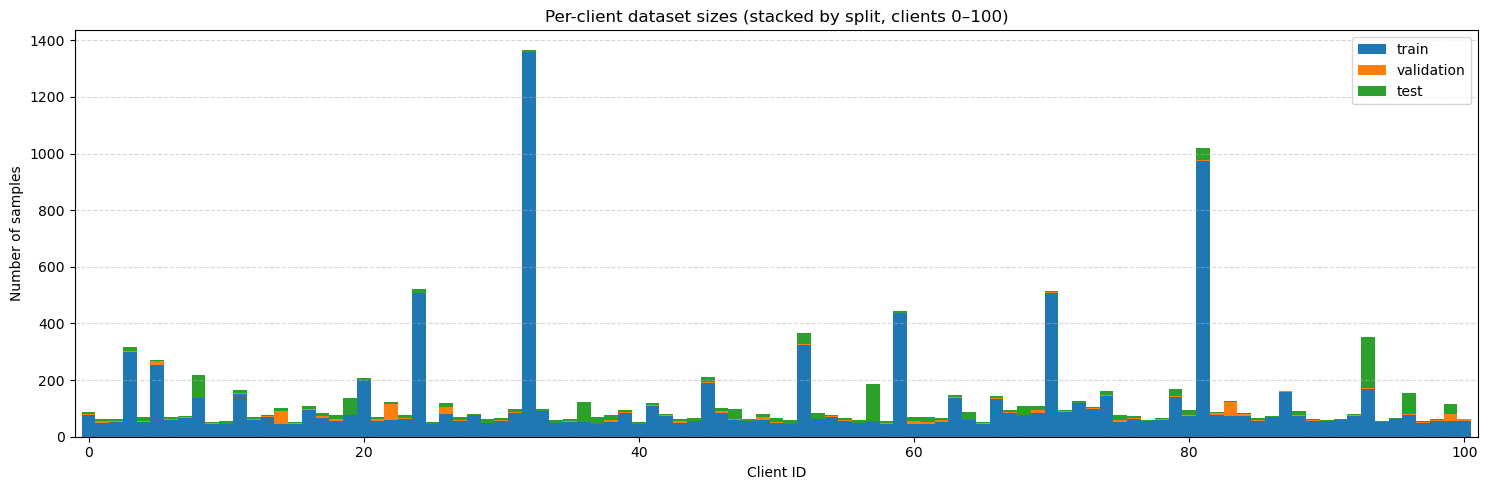

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
    "validation": MAPPING_DIR / "validation.csv",
    "test": MAPPING_DIR / "test.csv",
}

# -----------------------------
# Load counts
# -----------------------------
counts = {}
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    counts[split] = df.groupby("client_id").size()

# Restrict to client IDs 0–100
client_range = list(range(0, 101))

# Build stacked matrix: rows = clients, cols = splits
mat = np.zeros((len(client_range), len(CSV_FILES)), dtype=int)
split_names = list(CSV_FILES.keys())
for j, split in enumerate(split_names):
    s = counts[split]
    for i, cid in enumerate(client_range):
        if cid in s.index:
            mat[i, j] = s.loc[cid]

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(15, 5))
bottom = np.zeros(len(client_range), dtype=int)
colors = {"train": "tab:blue", "validation": "tab:orange", "test": "tab:green"}

for j, split in enumerate(split_names):
    ax.bar(client_range, mat[:, j], bottom=bottom,
           label=split, color=colors.get(split, None), width=1.0)
    bottom += mat[:, j]

ax.set_xlim(-1, 101)  # make sure we see exactly 0–100
ax.set_xlabel("Client ID")
ax.set_ylabel("Number of samples")
ax.set_title("Per-client dataset sizes (stacked by split, clients 0–100)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


Detected max client id in CSVs => using N = 12640 clients (ids 0..12639).


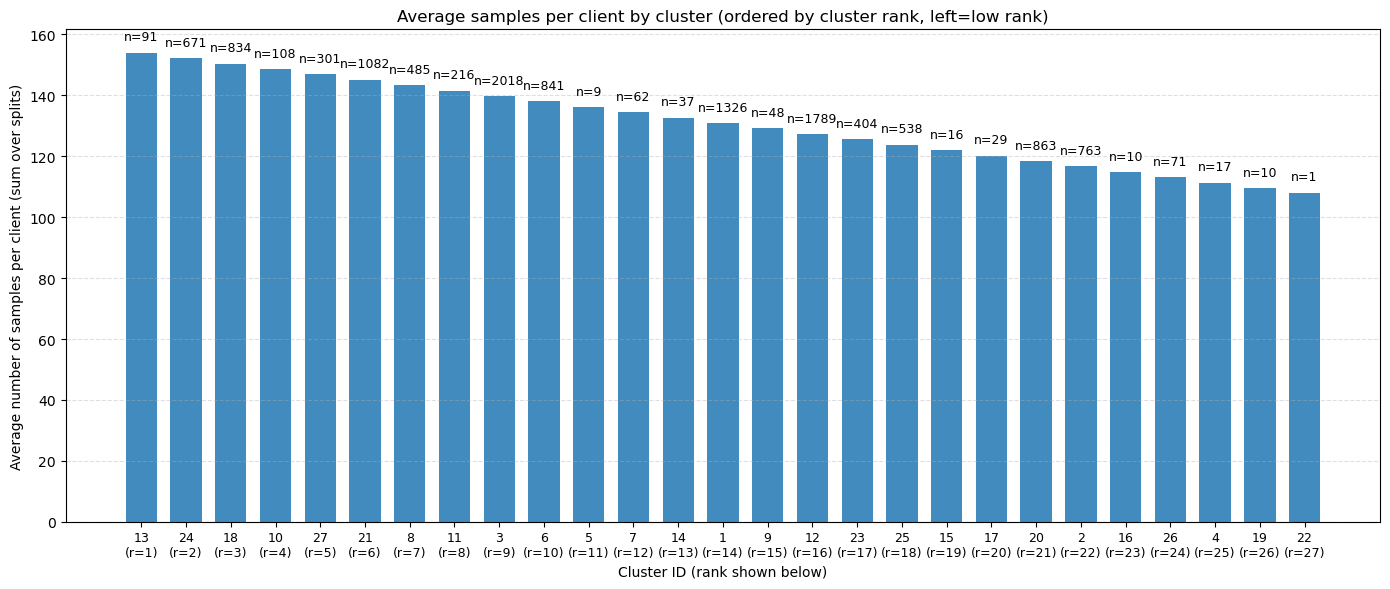

 cluster  rank  n_clients  avg_samples_per_client
      13   1.0         91              153.989011
      24   2.0        671              152.222057
      18   3.0        834              150.443645
      10   4.0        108              148.666667
      27   5.0        301              146.890365
      21   6.0       1082              145.113678
       8   7.0        485              143.336082
      11   8.0        216              141.560185
       3   9.0       2018              139.782458
       6  10.0        841              138.005945
       5  11.0          9              136.222222
       7  12.0         62              134.435484
      14  13.0         37              132.648649
       1  14.0       1326              130.898190
       9  15.0         48              129.125000
      12  16.0       1789              127.344326
      23  17.0        404              125.566832
      25  18.0        538              123.791822
      15  19.0         16              122.000000


In [4]:
import json
import pickle
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
    "validation": MAPPING_DIR / "validation.csv",
    "test": MAPPING_DIR / "test.csv",
}
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

# -----------------------------
# Load CSVs and compute per-client total counts
# -----------------------------
dfs = []
for p in CSV_FILES.values():
    if not p.exists():
        raise FileNotFoundError(f"{p} not found")
    dfs.append(pd.read_csv(p))
df = pd.concat(dfs, ignore_index=True)

# Total samples per client across all splits (include clients with zero later)
per_client_counts = df.groupby("client_id").size().to_dict()   # client_id -> count

# Determine N (assume CSVs contain new IDs 0..N-1; N = max_id+1)
N = int(df["client_id"].max()) + 1
print(f"Detected max client id in CSVs => using N = {N} clients (ids 0..{N-1}).")

# Build a dense vector of counts length N (clients with no rows -> 0)
counts_arr = np.zeros(N, dtype=int)
for cid, cnt in per_client_counts.items():
    counts_arr[int(cid)] = int(cnt)

# -----------------------------
# Load clients.pkl and clusters.json and build mapping new_id -> cluster & cluster ranks
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)

# model -> cluster_id mapping (ensure uniqueness) and cluster_id->rank
model_to_cluster = {}
cluster_rank = {}
for c in clusters:
    cid = int(c["id"])
    cluster_rank[cid] = float(c.get("rank", 0.0))
    for m in c.get("models", []):
        if m in model_to_cluster and model_to_cluster[m] != cid:
            raise RuntimeError(f"Model '{m}' appears in multiple clusters ({model_to_cluster[m]} and {cid})")
        model_to_cluster[m] = cid

with open(CLIENTS_PKL, "rb") as f:
    clients_obj = pickle.load(f)

# Build sorted entries (old_id, model) in ascending old_id order (same convention used when generating CSVs)
entries = []
if isinstance(clients_obj, dict):
    for v in clients_obj.values():
        entries.append((int(v["id"]), v["model"]))
elif isinstance(clients_obj, (list, tuple)):
    for v in clients_obj:
        entries.append((int(v["id"]), v["model"]))
else:
    raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")

entries.sort(key=lambda t: t[0])

if len(entries) < N:
    raise RuntimeError(f"clients.pkl has only {len(entries)} entries but we require first N={N}. Aborting.")

# new_id -> old_id mapping (we assume the same remapping as used in the partitioner)
new2old = {i: entries[i][0] for i in range(N)}
old2model = {old: model for (old, model) in entries}

# Build new_id -> cluster mapping (raise if model missing from clusters.json)
client_to_cluster = {}
for new_id in range(N):
    old_id = new2old[new_id]
    model = old2model.get(old_id)
    if model is None:
        raise RuntimeError(f"Old client id {old_id} not found in clients.pkl entries")
    if model not in model_to_cluster:
        raise RuntimeError(f"Model '{model}' (old_id={old_id}, new_id={new_id}) not found in clusters.json")
    client_to_cluster[new_id] = int(model_to_cluster[model])

# -----------------------------
# Aggregate: compute average samples per client for each cluster
# -----------------------------
cluster_to_client_ids = defaultdict(list)
for new_id, cluster_id in client_to_cluster.items():
    cluster_to_client_ids[cluster_id].append(new_id)

# Order clusters by their rank (ascending: rank=1 leftmost, higher ranks to the right).
# If a cluster has no rank entry, use 0.0 by default.
clusters_present = list(cluster_to_client_ids.keys())
clusters_sorted = sorted(clusters_present, key=lambda k: cluster_rank.get(k, 0.0))

cluster_means = []
cluster_counts = []
cluster_ranks_list = []
for k in clusters_sorted:
    cids = cluster_to_client_ids[k]
    arr = counts_arr[cids]                # vector of counts for clients in this cluster (includes zeros)
    mean = float(arr.mean())
    cluster_means.append(mean)
    cluster_counts.append(len(cids))
    cluster_ranks_list.append(cluster_rank.get(k, 0.0))

# -----------------------------
# Plot bar chart: avg samples per client per cluster (ordered by rank)
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(clusters_sorted))
ax.bar(x, cluster_means, width=0.7, color="tab:blue", alpha=0.85)
ax.set_xticks(x)

# show cluster id and rank in xtick labels for clarity
xtick_labels = [f"{int(k)}\n(r={cluster_rank.get(k,0):.2g})" for k in clusters_sorted]
ax.set_xticklabels(xtick_labels, rotation=0, fontsize=9)

ax.set_xlabel("Cluster ID (rank shown below)")
ax.set_ylabel("Average number of samples per client (sum over splits)")
ax.set_title("Average samples per client by cluster (ordered by cluster rank, left=low rank)")

# annotate with number of clients above each bar
max_mean = max(cluster_means) if cluster_means else 1.0
for xi, mean, cnt in zip(x, cluster_means, cluster_counts):
    ax.text(xi, mean + max_mean * 0.02, f"n={cnt}", ha="center", va="bottom", fontsize=9)

ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# -----------------------------
# Also print a small table for numeric inspection (ordered by rank)
# -----------------------------
tbl = pd.DataFrame({
    "cluster": clusters_sorted,
    "rank": cluster_ranks_list,
    "n_clients": cluster_counts,
    "avg_samples_per_client": cluster_means,
})
print(tbl.sort_values("rank").to_string(index=False))

/tmp/ipykernel_355776/397796112.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))
/users/eleves-a/2024/baptiste.geisenberger/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


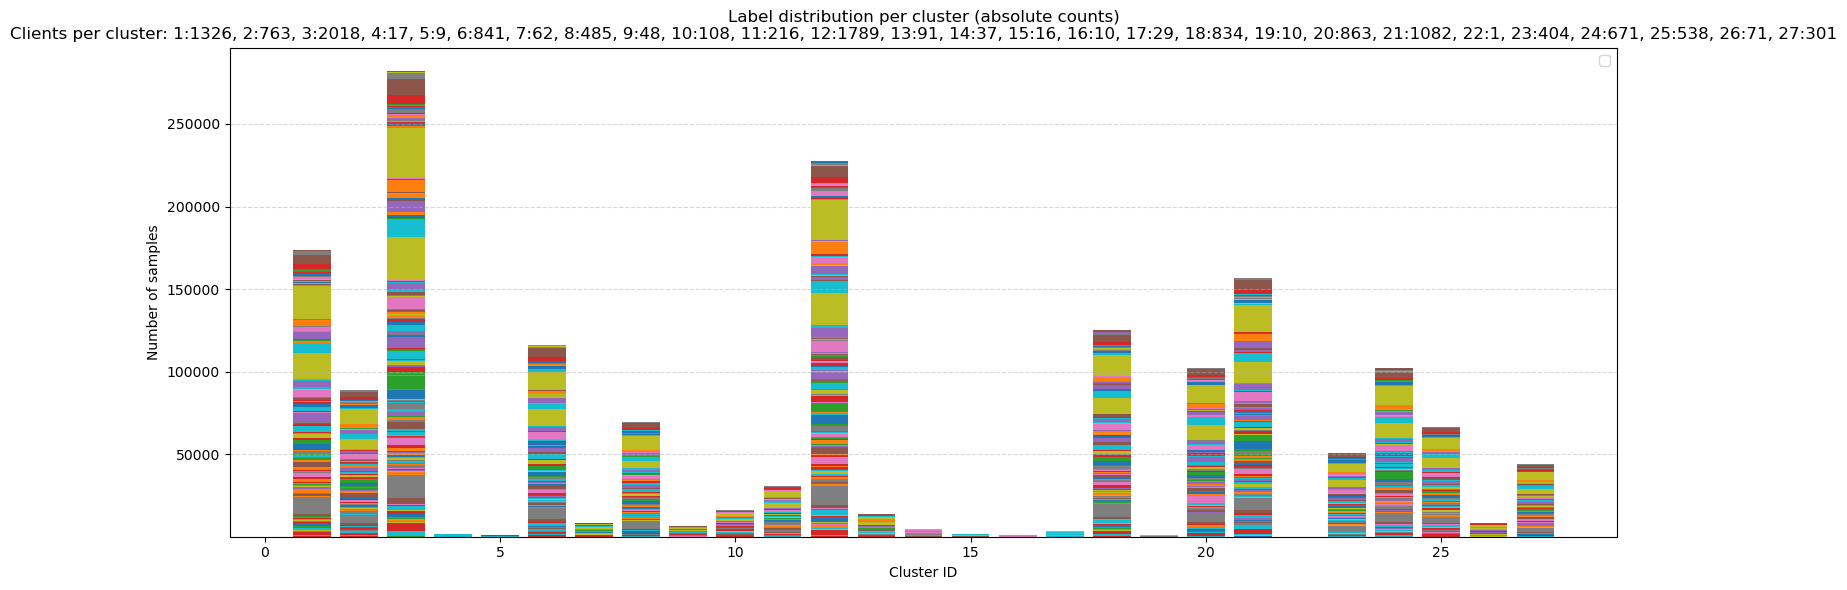

/tmp/ipykernel_355776/397796112.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))
/tmp/ipykernel_355776/397796112.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


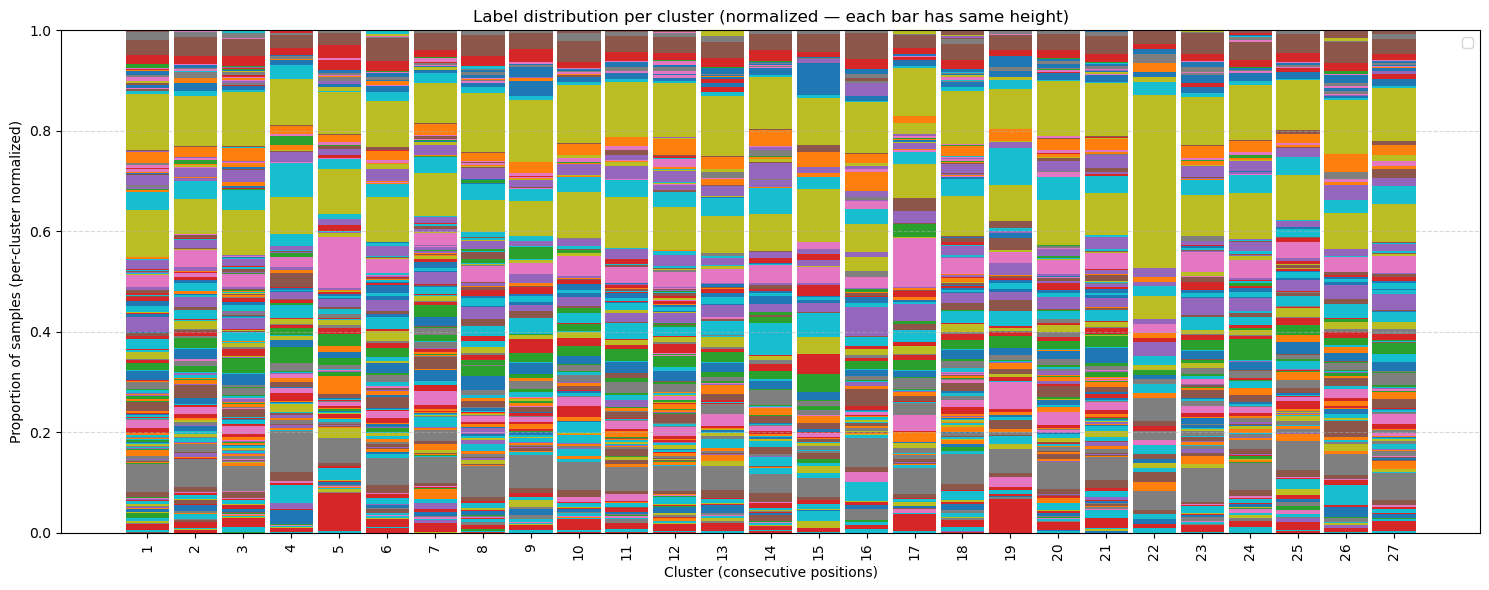

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
    "validation": MAPPING_DIR / "validation.csv",
    "test": MAPPING_DIR / "test.csv",
}
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

# -----------------------------
# Load partition data
# -----------------------------
df_all = []
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    df["split"] = split
    df_all.append(df)
df = pd.concat(df_all, ignore_index=True)

# -----------------------------
# Load cluster mapping
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)

model_to_cluster = {}
for c in clusters:
    for m in c["models"]:
        model_to_cluster[m] = c["id"]

with open(CLIENTS_PKL, "rb") as f:
    clients = pickle.load(f)

# Build client_id -> model
if isinstance(clients, dict):
    client_models = {int(v["id"]): v["model"] for v in clients.values()}
else:  # list-like
    client_models = {int(v["id"]): v["model"] for v in clients}

# Selected clients = those in CSVs
selected_clients = set(df["client_id"].unique())

# Build client_id -> cluster_id
client_to_cluster = {}
for cid in selected_clients:
    model = client_models[cid]
    if model not in model_to_cluster:
        raise RuntimeError(f"Model {model} (client {cid}) not found in clusters.json")
    client_to_cluster[cid] = model_to_cluster[model]

# -----------------------------
# Aggregate label counts per cluster
# -----------------------------
cluster_label_counts = defaultdict(Counter)
cluster_clients = defaultdict(set)

for _, row in df.iterrows():
    cid = int(row["client_id"])
    lab = row["label_name"]
    clus = client_to_cluster[cid]
    cluster_label_counts[clus][lab] += 1
    cluster_clients[clus].add(cid)

# All labels sorted for deterministic stacking
all_labels = sorted(df["label_name"].unique())

# -----------------------------
# Build DataFrame (clusters x labels)
# -----------------------------
clusters_sorted = sorted(cluster_label_counts.keys())
mat = []
for clus in clusters_sorted:
    counts = [cluster_label_counts[clus][lab] for lab in all_labels]
    mat.append(counts)
mat = pd.DataFrame(mat, index=clusters_sorted, columns=all_labels)

# -----------------------------
# 1) Absolute stacked bar chart
# -----------------------------
fig, ax = plt.subplots(figsize=(15, 6))
bottom = None
for lab in all_labels:
    vals = mat[lab].values
    ax.bar(clusters_sorted, vals, bottom=bottom, label=lab, width=0.8)
    if bottom is None:
        bottom = vals.copy()
    else:
        bottom = bottom + vals

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Number of samples")
ax.set_title("Label distribution per cluster (absolute counts)\nClients per cluster: " +
             ", ".join(f"{c}:{len(cluster_clients[c])}" for c in clusters_sorted))
ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Normalized stacked bar chart (all bars same total height)
# -----------------------------
# Normalize each cluster row to sum==1 (if a cluster has zero total, keep zeros)
row_sums = mat.sum(axis=1).replace(0, 1)   # avoid division by zero
mat_norm = mat.div(row_sums, axis=0)

fig, ax = plt.subplots(figsize=(15, 6))
bottom = None
for lab in all_labels:
    vals = mat_norm[lab].values
    ax.bar(range(len(clusters_sorted)), vals, bottom=bottom, label=lab, width=0.9)
    if bottom is None:
        bottom = vals.copy()
    else:
        bottom = bottom + vals

# x ticks are consecutive indices; label them with cluster ids for reference
ax.set_xticks(range(len(clusters_sorted)))
ax.set_xticklabels(clusters_sorted, rotation=90)

ax.set_xlabel("Cluster (consecutive positions)")
ax.set_ylabel("Proportion of samples (per-cluster normalized)")
ax.set_title("Label distribution per cluster (normalized — each bar has same height)")
ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

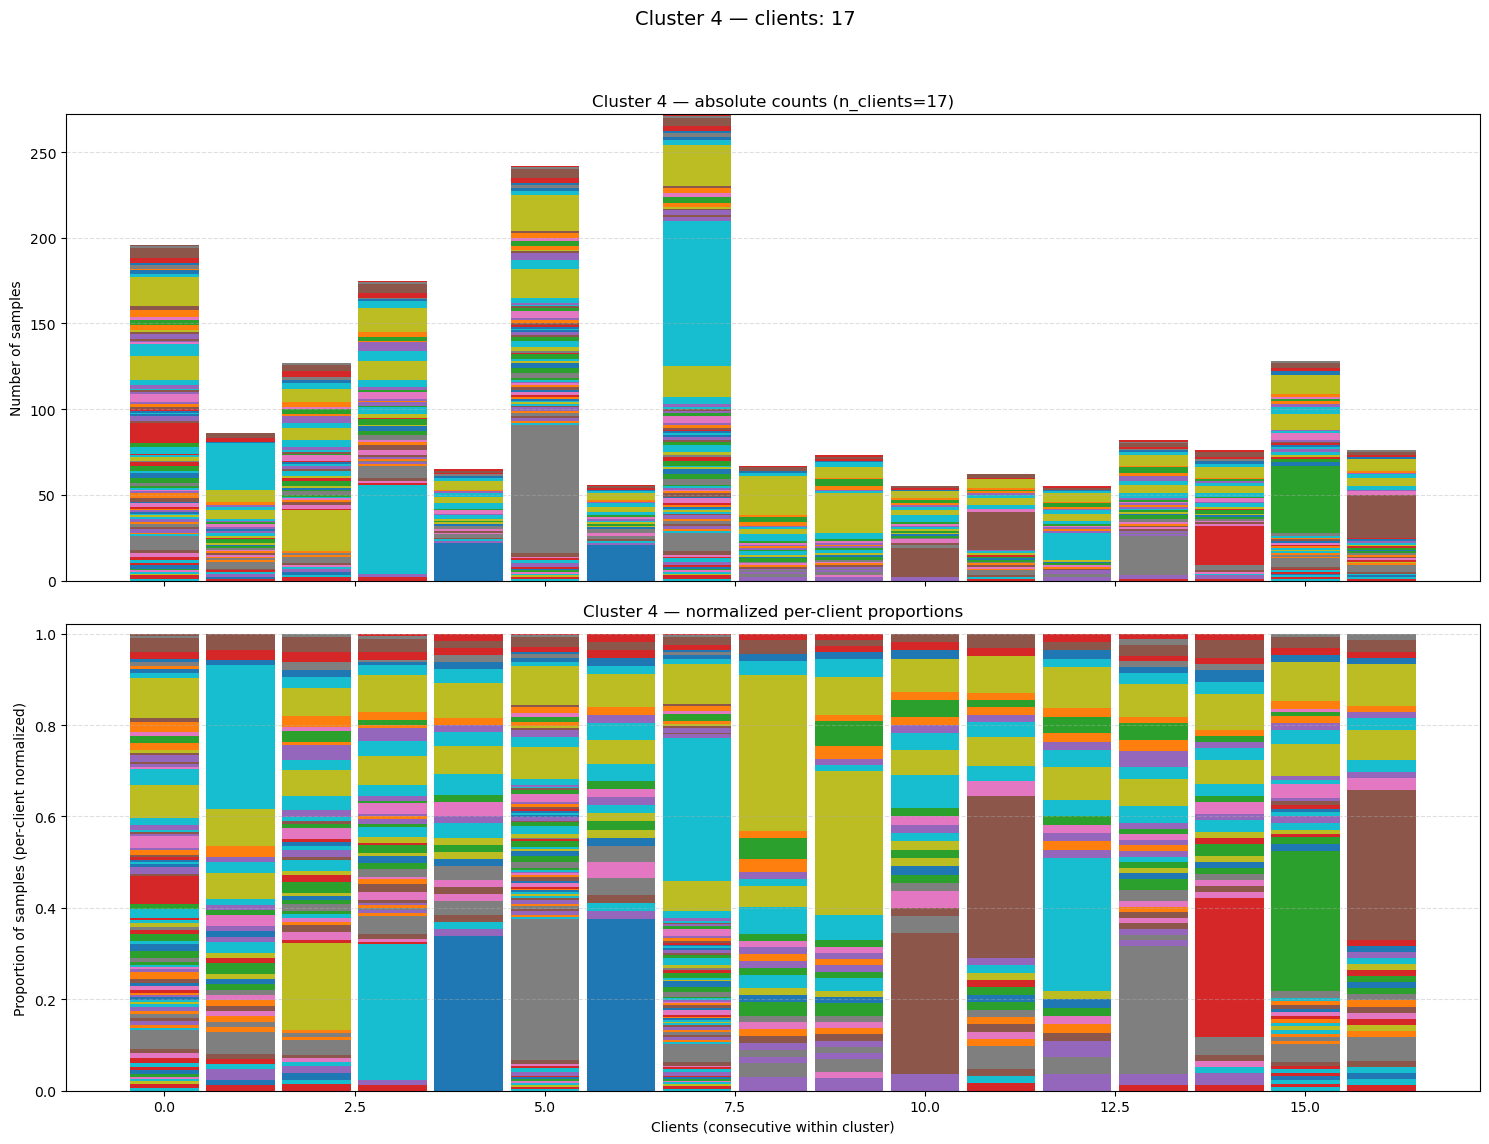

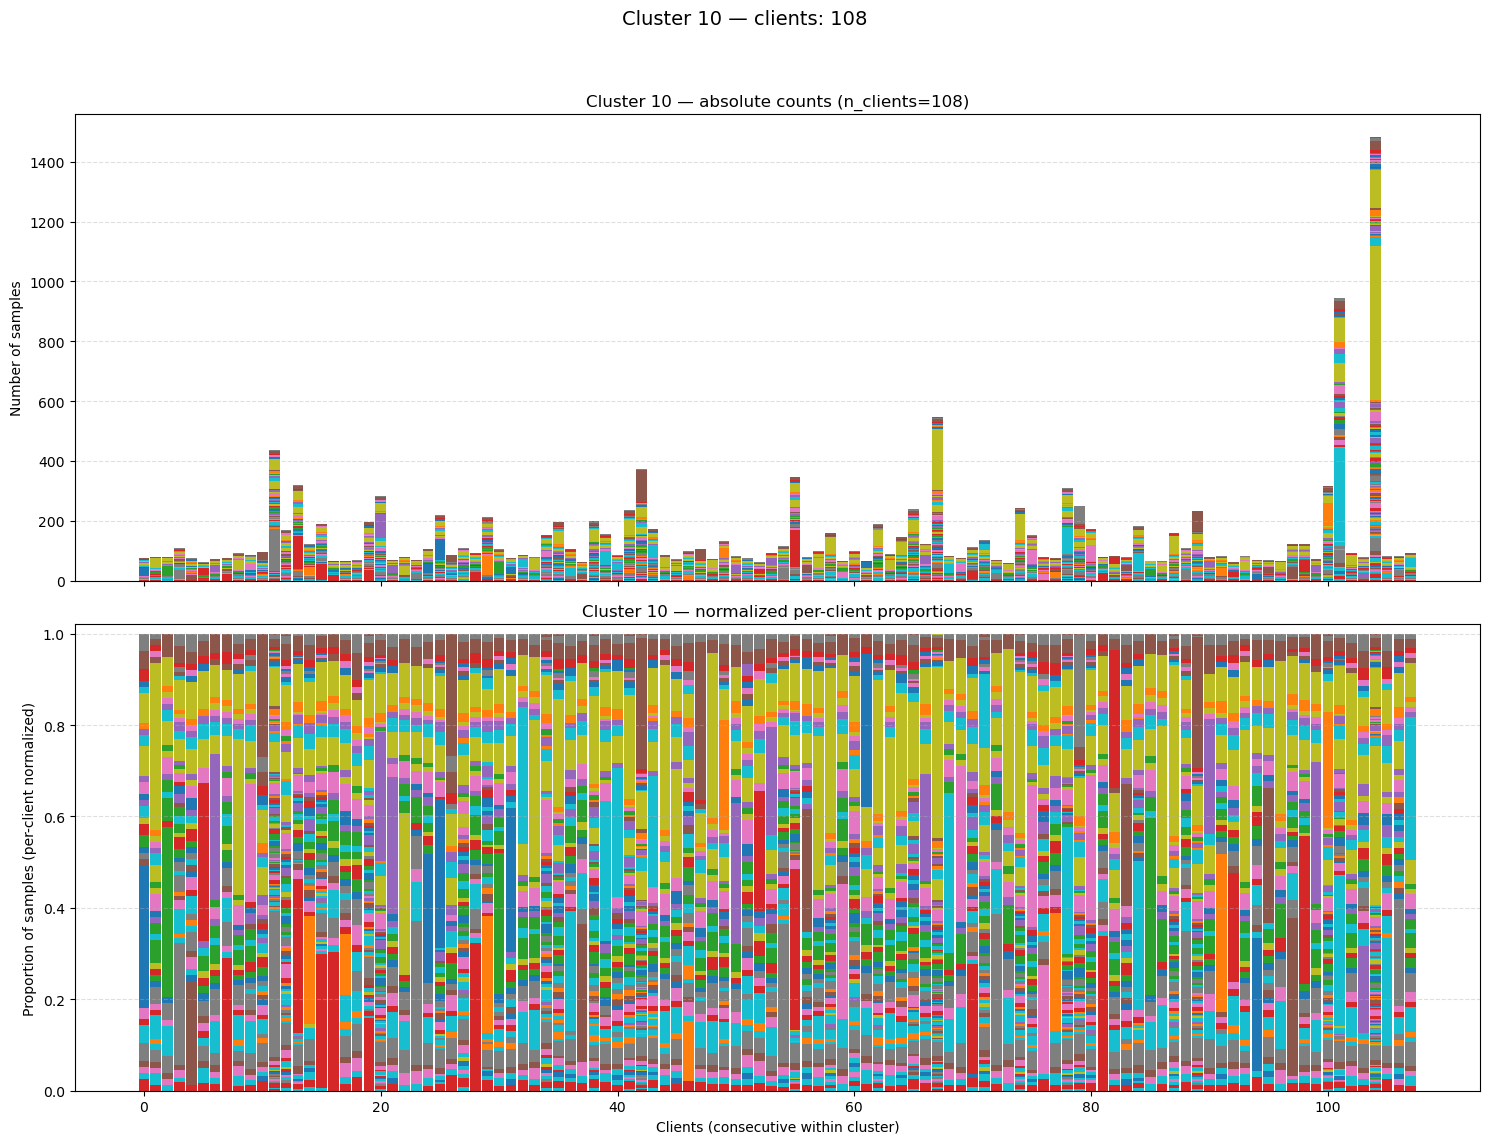

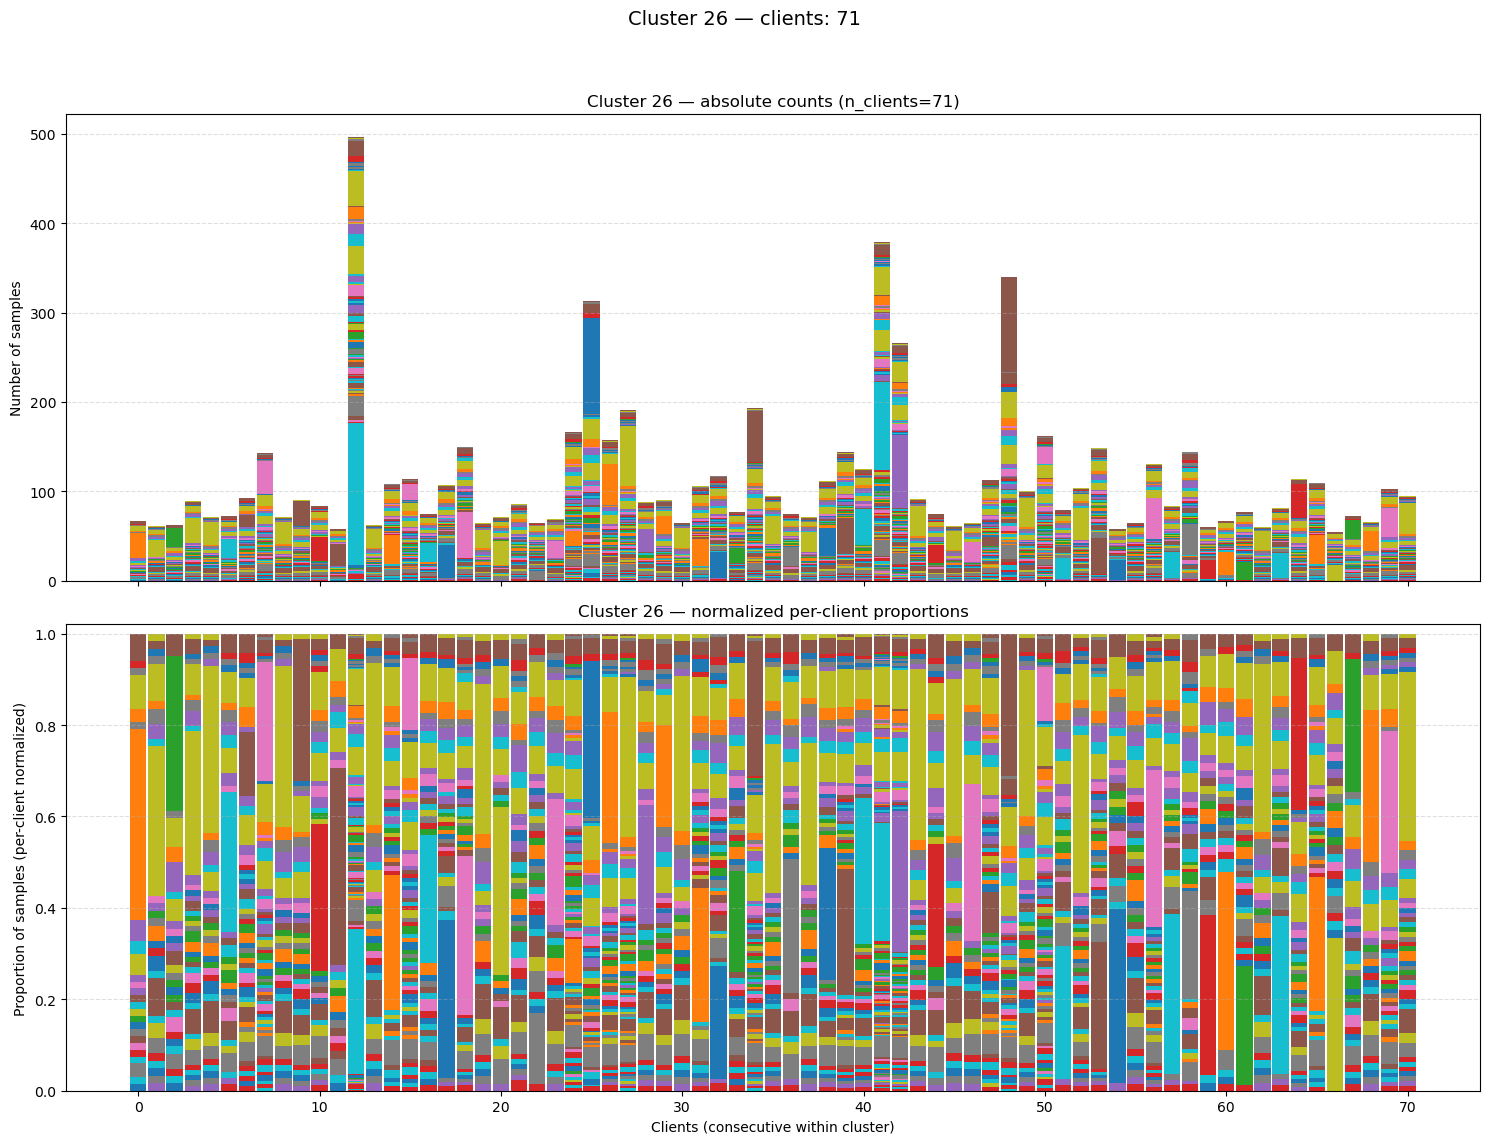

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
    "validation": MAPPING_DIR / "validation.csv",
    "test": MAPPING_DIR / "test.csv",
}
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

TARGET_CLUSTERS = [4, 10, 26]

# -----------------------------
# Load partition data
# -----------------------------
df_all = []
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    df_all.append(df)
df = pd.concat(df_all, ignore_index=True)

# -----------------------------
# Load clusters and clients
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)
model_to_cluster = {}
for c in clusters:
    for m in c.get("models", []):
        model_to_cluster[m] = c["id"]

with open(CLIENTS_PKL, "rb") as f:
    clients_obj = pickle.load(f)

entries = []
if isinstance(clients_obj, dict):
    for v in clients_obj.values():
        entries.append((int(v["id"]), v["model"]))
elif isinstance(clients_obj, (list, tuple)):
    for v in clients_obj:
        entries.append((int(v["id"]), v["model"]))
else:
    raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")

entries.sort(key=lambda t: t[0])
N = int(df["client_id"].max()) + 1
new2old = {i: entries[i][0] for i in range(N)}
oldid_to_model = {old: model for (old, model) in entries}

client_to_cluster = {}
for new_id in range(N):
    model = oldid_to_model[new2old[new_id]]
    if model not in model_to_cluster:
        raise RuntimeError(f"Model {model} not in clusters.json")
    client_to_cluster[new_id] = model_to_cluster[model]

# -----------------------------
# Aggregate label counts per client
# -----------------------------
client_label_counts = defaultdict(Counter)
for _, row in df.iterrows():
    cid = int(row["client_id"])
    lab = row["label_name"]
    client_label_counts[cid][lab] += 1

# -----------------------------
# Plot for target clusters (absolute above, normalized below)
# -----------------------------
labels = sorted(df["label_name"].unique())

for target_cluster in TARGET_CLUSTERS:
    # clients belonging to this cluster (consecutive index 0..M-1 used for plotting)
    cids = [cid for cid, clus in client_to_cluster.items() if clus == target_cluster]
    if not cids:
        print(f"No clients found for cluster {target_cluster}")
        continue

    # Build dataframe: rows = clients (consecutive index), cols = labels (absolute counts)
    mat_abs = []
    for cid in cids:
        mat_abs.append([client_label_counts[cid][lab] for lab in labels])
    mat_abs = pd.DataFrame(mat_abs, index=range(len(cids)), columns=labels)

    # Prepare normalized matrix: each row normalized to sum 1 (avoid division by zero)
    row_sums = mat_abs.sum(axis=1).replace(0, 1)  # keep zeros as zeros after division
    mat_norm = mat_abs.div(row_sums, axis=0)

    # Plot stacked vertically: absolute (top), normalized (bottom)
    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(15, 12), sharex=True,
                                         gridspec_kw={'height_ratios': [1, 1]})

    # --- Top: Absolute stacked bar chart ---
    bottom = None
    for lab in labels:
        vals = mat_abs[lab].values
        ax_top.bar(mat_abs.index, vals, bottom=bottom, label=lab, width=0.9)
        bottom = vals.copy() if bottom is None else bottom + vals
    ax_top.set_ylabel("Number of samples")
    ax_top.set_title(f"Cluster {target_cluster} — absolute counts (n_clients={len(cids)})")
    ax_top.grid(axis="y", linestyle="--", alpha=0.4)

    # --- Bottom: Normalized stacked bar chart (each client bar sums to 1) ---
    bottom = None
    x = list(range(len(cids)))
    for lab in labels:
        vals = mat_norm[lab].values
        ax_bot.bar(x, vals, bottom=bottom, label=lab, width=0.9)
        bottom = vals.copy() if bottom is None else bottom + vals
    ax_bot.set_xlabel("Clients (consecutive within cluster)")
    ax_bot.set_ylabel("Proportion of samples (per-client normalized)")
    ax_bot.set_ylim(0, 1.02)
    ax_bot.set_title(f"Cluster {target_cluster} — normalized per-client proportions")
    ax_bot.grid(axis="y", linestyle="--", alpha=0.4)

    # Legend handling: show only if label count small, else show top-10 labels by count
    if len(labels) <= 20:
        # show full legend below the bottom plot
        ax_bot.legend(ncol=4, bbox_to_anchor=(0.5, -0.35), loc="upper center")
    else:
        cluster_label_totals = mat_abs.sum(axis=0).sort_values(ascending=False)
        topk = cluster_label_totals.index[:10].tolist()
        handles, lablist = ax_bot.get_legend_handles_labels()
        lbl2h = dict(zip(lablist, handles))
        sel_handles = [lbl2h[l] for l in topk if l in lbl2h]
        if sel_handles:
            ax_bot.legend(sel_handles, topk, title="Top labels", bbox_to_anchor=(0.5, -0.35), loc="upper center")

    plt.suptitle(f"Cluster {target_cluster} — clients: {len(cids)}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

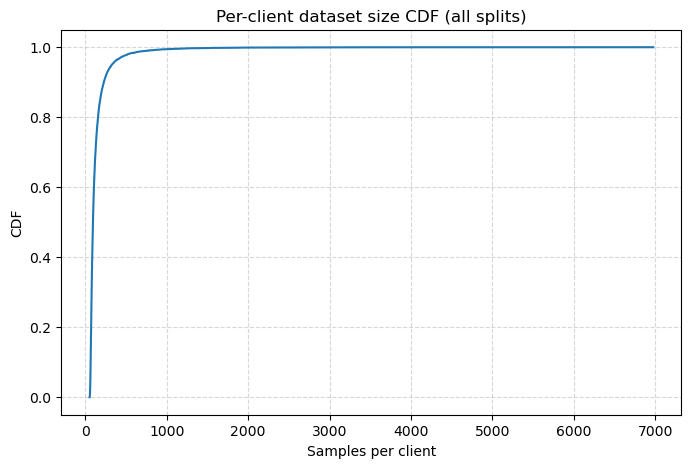

N clients with data: 12640, mean=134.9, std=171.0, p50=92, p90=226, p99=767


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
paths = [MAPPING_DIR/"train.csv", MAPPING_DIR/"validation.csv", MAPPING_DIR/"test.csv"]

df = pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)
sizes = df.groupby("client_id").size().astype(int).sort_values().values

cdf_x = np.sort(sizes)
cdf_y = np.arange(1, len(cdf_x)+1) / len(cdf_x)

plt.figure(figsize=(8,5))
plt.plot(cdf_x, cdf_y)
plt.xlabel("Samples per client")
plt.ylabel("CDF")
plt.title("Per-client dataset size CDF (all splits)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

print(f"N clients with data: {len(sizes)}, mean={sizes.mean():.1f}, std={sizes.std():.1f}, "
      f"p50={np.percentile(sizes,50):.0f}, p90={np.percentile(sizes,90):.0f}, p99={np.percentile(sizes,99):.0f}")


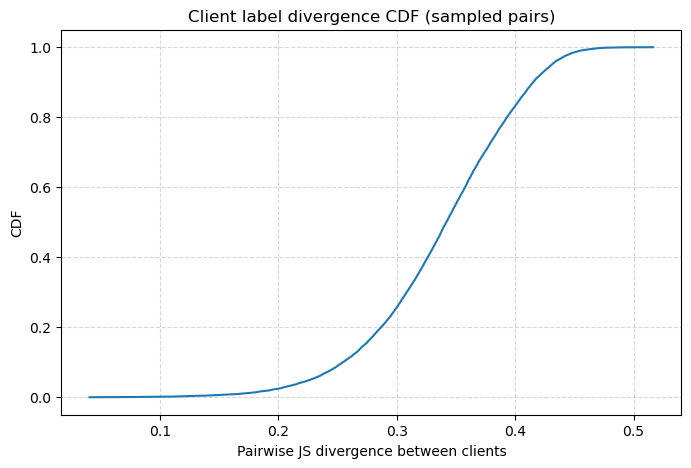

Pairs=19999 | JS: mean=0.337, median=0.342, p10=0.254, p90=0.415


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict, Counter
from itertools import combinations
import random

def js_divergence(p, q, eps=1e-12):
    p = np.maximum(p, eps); p /= p.sum()
    q = np.maximum(q, eps); q /= q.sum()
    m = 0.5*(p+q)
    def kl(a,b): return np.sum(a*(np.log(a)-np.log(b)))
    return 0.5*kl(p,m)+0.5*kl(q,m)

MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
paths = [MAPPING_DIR/"train.csv", MAPPING_DIR/"validation.csv", MAPPING_DIR/"test.csv"]

df = pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)
labels = sorted(df["label_name"].unique())
lid = {l:i for i,l in enumerate(labels)}
L = len(labels)

# Build client label distributions
g = df.groupby(["client_id","label_name"]).size().reset_index(name="cnt")
clients = sorted(g["client_id"].unique())
C = len(clients)

mat = np.zeros((C, L), dtype=float)
cid_index = {c:i for i,c in enumerate(clients)}
for _, row in g.iterrows():
    mat[cid_index[row["client_id"]], lid[row["label_name"]]] = row["cnt"]
mat = (mat.T / (mat.sum(axis=1)+1e-12)).T

# Sample pairs
random.seed(42)
MAX_PAIRS = 20000  # adjust if you want more/less precision
pairs = []
if C*(C-1)//2 <= MAX_PAIRS:
    pairs = list(combinations(range(C),2))
else:
    for _ in range(MAX_PAIRS):
        a, b = random.sample(range(C), 2)
        if a>b: a,b=b,a
        pairs.append((a,b))
    pairs = list(set(pairs))  # de-dup small chance

js_vals = np.array([js_divergence(mat[i], mat[j]) for i,j in pairs])
js_vals.sort()
cdf_y = np.arange(1, len(js_vals)+1)/len(js_vals)

plt.figure(figsize=(8,5))
plt.plot(js_vals, cdf_y)
plt.xlabel("Pairwise JS divergence between clients")
plt.ylabel("CDF")
plt.title("Client label divergence CDF (sampled pairs)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

print(f"Pairs={len(js_vals)} | JS: mean={js_vals.mean():.3f}, median={np.median(js_vals):.3f}, "
      f"p10={np.percentile(js_vals,10):.3f}, p90={np.percentile(js_vals,90):.3f}")


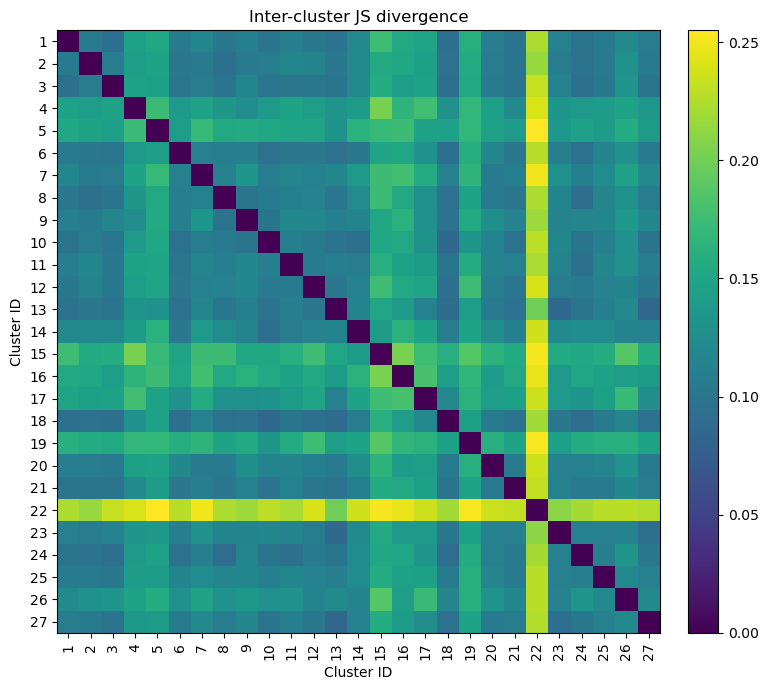

Inter-cluster JS: mean=0.134, median=0.124, min=0.084, max=0.255, pairs=351


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

def js_divergence(p, q, eps=1e-12):
    p = np.maximum(p, eps); p /= p.sum()
    q = np.maximum(q, eps); q /= q.sum()
    m = 0.5*(p+q)
    def kl(a,b): return np.sum(a*(np.log(a)-np.log(b)))
    return 0.5*kl(p,m)+0.5*kl(q,m)

MAPPING_DIR   = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

df = pd.concat([pd.read_csv(MAPPING_DIR/"train.csv"),
                pd.read_csv(MAPPING_DIR/"validation.csv"),
                pd.read_csv(MAPPING_DIR/"test.csv")], ignore_index=True)

# label ids
labels = sorted(df["label_name"].unique())
lid = {l:i for i,l in enumerate(labels)}
L = len(labels)

# Rebuild new_id -> cluster_id (same logic as earlier)
with open(CLUSTERS_JSON, "r") as f: clusters = json.load(f)
model_to_cluster = {m:c["id"] for c in clusters for m in c.get("models", [])}

with open(CLIENTS_PKL, "rb") as f: clients_obj = pickle.load(f)
entries = [(int(v["id"]), v["model"]) for v in (clients_obj.values() if isinstance(clients_obj, dict) else clients_obj)]
entries.sort(key=lambda t:t[0])
N = df["client_id"].max()+1
new2old = {i: entries[i][0] for i in range(N)}
old2model = dict(entries)
client_to_cluster = {i: model_to_cluster[old2model[new2old[i]]] for i in range(N) 
                     if old2model[new2old[i]] in model_to_cluster}

# Build cluster distributions
cluster_counts = defaultdict(lambda: np.zeros(L, dtype=float))
for _, r in df.iterrows():
    c = int(r["client_id"])
    if c not in client_to_cluster: continue
    k = client_to_cluster[c]
    cluster_counts[k][lid[r["label_name"]]] += 1

clusters_sorted = sorted(cluster_counts.keys())
P = {k: (v / (v.sum()+1e-12)) for k,v in cluster_counts.items()}

# Pairwise JS and heatmap
K = len(clusters_sorted)
mat = np.zeros((K,K), dtype=float)
for i, ki in enumerate(clusters_sorted):
    for j, kj in enumerate(clusters_sorted):
        if i==j: continue
        mat[i,j] = js_divergence(P[ki], P[kj])

plt.figure(figsize=(8,7))
im = plt.imshow(mat, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Inter-cluster JS divergence")
plt.xlabel("Cluster ID"); plt.ylabel("Cluster ID")
plt.xticks(range(K), clusters_sorted, rotation=90)
plt.yticks(range(K), clusters_sorted)
plt.tight_layout(); plt.show()

tri = mat[np.triu_indices(K, k=1)]
print(f"Inter-cluster JS: mean={tri.mean():.3f}, median={np.median(tri):.3f}, "
      f"min={tri.min():.3f}, max={tri.max():.3f}, pairs={len(tri)}")


/tmp/ipykernel_355776/997582633.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=clusters_sorted, showfliers=False)


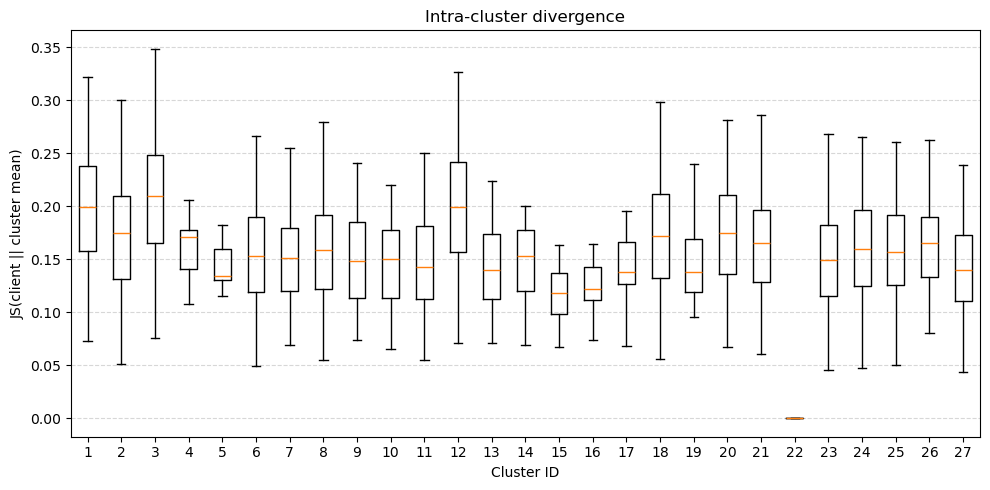

Mean / median JS per cluster (intra-cluster):
  1: mean=0.198, median=0.199, n=1326
  2: mean=0.172, median=0.174, n=763
  3: mean=0.208, median=0.209, n=2018
  4: mean=0.160, median=0.171, n=17
  5: mean=0.145, median=0.134, n=9
  6: mean=0.154, median=0.153, n=841
  7: mean=0.152, median=0.151, n=62
  8: mean=0.158, median=0.159, n=485
  9: mean=0.150, median=0.148, n=48
  10: mean=0.145, median=0.150, n=108
  11: mean=0.146, median=0.142, n=216
  12: mean=0.199, median=0.199, n=1789
  13: mean=0.145, median=0.140, n=91
  14: mean=0.147, median=0.153, n=37
  15: mean=0.117, median=0.118, n=16
  16: mean=0.124, median=0.122, n=10
  17: mean=0.141, median=0.138, n=29
  18: mean=0.172, median=0.172, n=834
  19: mean=0.151, median=0.138, n=10
  20: mean=0.174, median=0.175, n=863
  21: mean=0.164, median=0.165, n=1082
  22: mean=0.000, median=0.000, n=1
  23: mean=0.149, median=0.149, n=404
  24: mean=0.161, median=0.159, n=671
  25: mean=0.157, median=0.157, n=538
  26: mean=0.165, medi

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

def js_divergence(p, q, eps=1e-12):
    p = np.maximum(p, eps); p /= p.sum()
    q = np.maximum(q, eps); q /= q.sum()
    m = 0.5*(p+q)
    def kl(a,b): return np.sum(a*(np.log(a)-np.log(b)))
    return 0.5*kl(p,m)+0.5*kl(q,m)

MAPPING_DIR   = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

# load combined mapping
df = pd.concat([pd.read_csv(MAPPING_DIR/"train.csv"),
                pd.read_csv(MAPPING_DIR/"validation.csv"),
                pd.read_csv(MAPPING_DIR/"test.csv")], ignore_index=True)

# label indexing
labels = sorted(df["label_name"].unique())
lid = {l:i for i,l in enumerate(labels)}
L = len(labels)

# load clusters -> model->cluster map
with open(CLUSTERS_JSON, "r") as f: clusters = json.load(f)
model_to_cluster = {m:c["id"] for c in clusters for m in c.get("models", [])}

# load clients.pkl to map client id -> model -> cluster
with open(CLIENTS_PKL, "rb") as f: clients_obj = pickle.load(f)
entries = [(int(v["id"]), v["model"]) for v in (clients_obj.values() if isinstance(clients_obj, dict) else clients_obj)]
entries.sort(key=lambda t:t[0])
N = df["client_id"].max()+1
new2old = {i: entries[i][0] for i in range(N)}
old2model = dict(entries)
client_to_cluster = {i: model_to_cluster[old2model[new2old[i]]] for i in range(N)
                     if old2model[new2old[i]] in model_to_cluster}

# Per-client empirical distributions (counts -> normalized)
g = df.groupby(["client_id","label_name"]).size().reset_index(name="cnt")
clients = sorted(g["client_id"].unique())
C = len(clients)
mat_counts = np.zeros((C, L), dtype=float)
cid_index = {c:i for i,c in enumerate(clients)}
for _, row in g.iterrows():
    mat_counts[cid_index[row["client_id"]], lid[row["label_name"]]] = row["cnt"]
# row-normalized per-client distributions (rows sum approx 1)
mat = (mat_counts.T / (mat_counts.sum(axis=1)+1e-12)).T

# Cluster -> client indices
clus_to_idx = defaultdict(list)
for c in clients:
    if c in client_to_cluster:
        clus_to_idx[client_to_cluster[c]].append(cid_index[c])

# Compute JS(client || cluster_mean) (intra-cluster)
cluster_js = {}
for k, idxs in clus_to_idx.items():
    if len(idxs) == 0:
        continue
    mean_k = mat[idxs].mean(axis=0)
    vals = [js_divergence(mat[i], mean_k) for i in idxs]
    cluster_js[k] = vals

# Plot box across clusters (intra-cluster)
clusters_sorted = sorted(cluster_js.keys())
data = [cluster_js[k] for k in clusters_sorted]
plt.figure(figsize=(10,5))
plt.boxplot(data, labels=clusters_sorted, showfliers=False)
plt.xlabel("Cluster ID"); plt.ylabel("JS(client || cluster mean)")
plt.title("Intra-cluster divergence")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout(); plt.show()

# Per-cluster summary (intra-cluster)
summ = {k: (np.mean(v), np.median(v)) for k,v in cluster_js.items()}
print("Mean / median JS per cluster (intra-cluster):")
for k in clusters_sorted:
    m, md = summ[k]
    print(f"  {k}: mean={m:.3f}, median={md:.3f}, n={len(cluster_js[k])}")

# Mean of per-cluster means (mean of means)
cluster_means = np.array([summ[k][0] for k in clusters_sorted], dtype=float)
mean_of_cluster_means = float(np.mean(cluster_means)) if cluster_means.size > 0 else float("nan")
print(f"\nMean of per-cluster mean JS (intra-cluster mean-of-means): {mean_of_cluster_means:.6f}")

# ---- New: weighted mean by clients of per-cluster mean JS ----
# weights = number of clients in each cluster (proportional to total clients)
cluster_sizes = np.array([len(clus_to_idx[k]) for k in clusters_sorted], dtype=float)
total_cluster_clients = float(cluster_sizes.sum()) if cluster_sizes.size > 0 else 0.0
if total_cluster_clients > 0 and cluster_means.size == cluster_sizes.size:
    weighted_mean_of_cluster_means = float(np.sum(cluster_means * cluster_sizes) / total_cluster_clients)
else:
    weighted_mean_of_cluster_means = float("nan")

print(f"Weighted mean by clients of per-cluster mean JS (intra-cluster mean-of-means): {weighted_mean_of_cluster_means:.6f}")
print(f"  (computed over {int(total_cluster_clients)} clients across {len(clusters_sorted)} clusters)")

# -----------------------------
# JS(client || GLOBAL mean) summary (kept but without per-client prints)
# -----------------------------
global_label_counts = df["label_name"].value_counts()
global_counts_vec = np.zeros(L, dtype=float)
for lbl, cnt in global_label_counts.items():
    global_counts_vec[lid[lbl]] = cnt
global_p = global_counts_vec / (global_counts_vec.sum() + 1e-12)

js_client_global = np.array([js_divergence(mat[i], global_p) for i in range(C)], dtype=float)

print("\nJS-to-global summary across clients:")
print(f"  num clients considered = {C}")
print(f"  mean = {js_client_global.mean():.6f}")
print(f"  median = {np.median(js_client_global):.6f}")
print(f"  std = {js_client_global.std():.6f}")
print(f"  min = {js_client_global.min():.6f}")
print(f"  max = {js_client_global.max():.6f}")

Loaded rows: 1705509
Unique clients in OG mapping: 12640
Number of labels: 596
Num clients considered (distinct client_ids found in OG CSVs): 12640
Selected 12640 clients for JS computation (use_all=True).
Computed global client-average distribution in 0.012s
Computed JS for 12640 clients in 0.208s (total elapsed 43.371s)
JS stats (nats): mean=0.2448, median=0.2468, std=0.0623, min=0.0461, max=0.4024


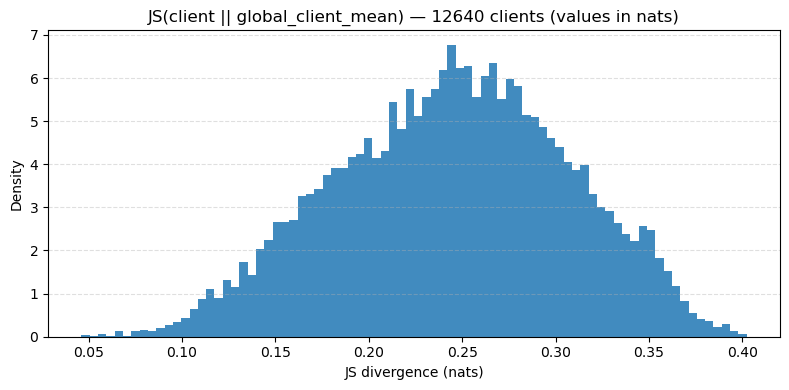

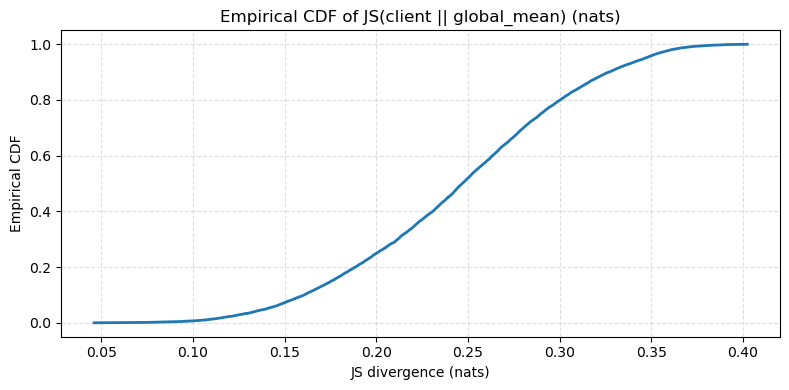


Top 10 clients (largest JS) among the selection:
  client_index=3534 (selection idx), client_id=3534, JS(nats)=0.4024
  client_index=7378 (selection idx), client_id=7378, JS(nats)=0.4015
  client_index=8171 (selection idx), client_id=8171, JS(nats)=0.3980
  client_index=7549 (selection idx), client_id=7549, JS(nats)=0.3980
  client_index=7297 (selection idx), client_id=7297, JS(nats)=0.3969
  client_index=7283 (selection idx), client_id=7283, JS(nats)=0.3966
  client_index=7296 (selection idx), client_id=7296, JS(nats)=0.3959
  client_index=4870 (selection idx), client_id=4870, JS(nats)=0.3954
  client_index=9140 (selection idx), client_id=9140, JS(nats)=0.3946
  client_index=11693 (selection idx), client_id=11693, JS(nats)=0.3943

Bottom 10 clients (smallest JS) among the selection:
  client_index=862, client_id=862, JS(nats)=0.0461
  client_index=32, client_id=32, JS(nats)=0.0483
  client_index=8170, client_id=8170, JS(nats)=0.0538
  client_index=11851, client_id=11851, JS(nats)=0.0

In [11]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

# -------------------------
# Config
# -------------------------
MAPPING_DIR_OG = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CSV_FILES = [
    MAPPING_DIR_OG / "train.csv",
    MAPPING_DIR_OG / "validation.csv",
    MAPPING_DIR_OG / "test.csv",
]
RNG_SEED = 12345
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

# If N_SELECT is None -> use ALL clients
# If N_SELECT is an integer < total clients -> randomly sample that many clients (reproducible by RNG_SEED)
# If N_SELECT >= total clients -> use all clients
N_SELECT = 100000   # <-- set this to how many clients you want to compute JS on (None or int)

# Safety: avoid accidentally huge runs; you can increase if you want
MAX_ALLOW = 100000  # allow up to this many clients for a single run (practical guard)
# -------------------------
# Helpers
# -------------------------
def js_divergence_batch(P, Q, eps=1e-12):
    """
    P: (B, L) or (L,) ; Q: (L,) or (B, L)
    Returns: (B,) JS divergences (in nats)
    """
    P = np.maximum(P, eps)
    Q = np.maximum(Q, eps)
    # Ensure shapes
    if P.ndim == 1:
        P = P[None, :]
    if Q.ndim == 1:
        Q = Q[None, :]
    M = 0.5 * (P + Q)
    klP = np.sum(P * (np.log(P) - np.log(M)), axis=1)
    klQ = np.sum(Q * (np.log(Q) - np.log(M)), axis=1)
    return 0.5 * (klP + klQ)

# -------------------------
# Load OG CSVs and build per-client label distributions
# -------------------------
start_all = time.time()
dfs = []
for p in CSV_FILES:
    if not p.exists():
        raise FileNotFoundError(f"{p} not found")
    dfs.append(pd.read_csv(p))
df = pd.concat(dfs, ignore_index=True)
print("Loaded rows:", len(df))
print("Unique clients in OG mapping:", df["client_id"].nunique())

labels = sorted(df["label_name"].unique())
lid = {l:i for i,l in enumerate(labels)}
L = len(labels)
print("Number of labels:", L)

# group counts per client x label
g = df.groupby(["client_id","label_name"]).size().reset_index(name="cnt")
clients = sorted(g["client_id"].unique())
C = len(clients)
print("Num clients considered (distinct client_ids found in OG CSVs):", C)

cid_index = {c:i for i,c in enumerate(clients)}
mat_counts = np.zeros((C, L), dtype=np.float64)
for _, row in g.iterrows():
    i = cid_index[row["client_id"]]
    j = lid[row["label_name"]]
    mat_counts[i, j] = row["cnt"]

# convert to empirical distributions (rows sum to 1)
row_sums = mat_counts.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
mat = mat_counts / row_sums   # shape (C, L)

# -------------------------
# Select subset of clients (time-aware / user-controlled)
# -------------------------
if N_SELECT is None:
    use_all = True
    n_use = C
else:
    n_use = int(N_SELECT)
    use_all = (n_use >= C)

if use_all:
    sel_idx = np.arange(C)
    n_use = C
else:
    if n_use > MAX_ALLOW:
        raise RuntimeError(f"N_SELECT={n_use} exceeds safety MAX_ALLOW={MAX_ALLOW}. Reduce N_SELECT or raise MAX_ALLOW.")
    sel_idx = np.random.choice(np.arange(C), size=n_use, replace=False)

print(f"Selected {n_use} clients for JS computation (use_all={use_all}).")

# -------------------------
# Compute global client-average distribution (mean over selected client rows)
# -------------------------
t0 = time.time()
global_mean = mat[sel_idx].mean(axis=0)   # shape (L,)
global_mean /= (global_mean.sum() + 1e-12)  # numeric safety
t1 = time.time()
print(f"Computed global client-average distribution in {t1-t0:.3f}s")

# -------------------------
# Compute JS(client || global_mean) for selected clients (JS in nats)
# -------------------------
t0 = time.time()
P = mat[sel_idx]          # (n_use, L)
Q = global_mean           # (L,)
js_vals = js_divergence_batch(P, Q)   # (n_use,)
t1 = time.time()
print(f"Computed JS for {n_use} clients in {t1-t0:.3f}s (total elapsed {time.time()-start_all:.3f}s)")

# -------------------------
# Summaries & plots (JS in nats; directly comparable to your cluster JS)
# -------------------------
print("JS stats (nats): mean={:.4f}, median={:.4f}, std={:.4f}, min={:.4f}, max={:.4f}"
      .format(js_vals.mean(), np.median(js_vals), js_vals.std(), js_vals.min(), js_vals.max()))

# Histogram
plt.figure(figsize=(8,4))
plt.hist(js_vals, bins=80, density=True, alpha=0.85)
plt.xlabel("JS divergence (nats)")
plt.ylabel("Density")
plt.title(f"JS(client || global_client_mean) — {n_use} clients (values in nats)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# CDF
plt.figure(figsize=(8,4))
xs = np.sort(js_vals)
ys = np.linspace(0,1,len(xs))
plt.plot(xs, ys, lw=2)
plt.xlabel("JS divergence (nats)")
plt.ylabel("Empirical CDF")
plt.title("Empirical CDF of JS(client || global_mean) (nats)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Top/bottom clients (by JS)
K = 10
order = np.argsort(js_vals)
bottom_k = order[:K]
top_k = order[-K:][::-1]
print(f"\nTop {K} clients (largest JS) among the selection:")
for pos in top_k:
    orig_cid = clients[int(sel_idx[pos])]
    print(f"  client_index={pos} (selection idx), client_id={orig_cid}, JS(nats)={js_vals[pos]:.4f}")

print(f"\nBottom {K} clients (smallest JS) among the selection:")
for pos in bottom_k:
    orig_cid = clients[int(sel_idx[pos])]
    print(f"  client_index={pos}, client_id={orig_cid}, JS(nats)={js_vals[pos]:.4f}")

# Quick numeric quantiles
q = [0,1,5,10,25,50,75,90,95,99,100]
qs = np.percentile(js_vals, q)
print("\nQuantiles (percentile : value in nats):")
for pct, val in zip(q, qs):
    print(f"  {pct:3d}% : {val:.4f}")

print("\nDone.")

In [12]:
import pandas as pd
import numpy as np
import json, pickle, math
from pathlib import Path
from collections import defaultdict, Counter
from itertools import combinations

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR   = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
    "validation": MAPPING_DIR / "validation.csv",
    "test": MAPPING_DIR / "test.csv",
}
# If you used fewer than all clients in clients.pkl, N is inferred from CSVs.

# -----------------------------
# Helpers
# -----------------------------
def js_divergence(p, q, eps=1e-12):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = np.maximum(p, eps); p /= p.sum()
    q = np.maximum(q, eps); q /= q.sum()
    m = 0.5 * (p + q)
    def kl(a, b):
        return np.sum(a * (np.log(a) - np.log(b)))
    return 0.5 * kl(p, m) + 0.5 * kl(q, m)

def cosine_similarity(p, q, eps=1e-12):
    p = np.asarray(p, float); q = np.asarray(q, float)
    num = np.dot(p, q)
    den = (np.linalg.norm(p) * np.linalg.norm(q)) + eps
    return float(num / den)

def gini_coefficient(x):
    # x must be non-negative
    x = np.asarray(x, dtype=float)
    if np.all(x == 0): 
        return 0.0
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    return float(gini)

# -----------------------------
# Load partition data
# -----------------------------
dfs = []
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    df["split"] = split
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

labels = sorted(df["label_name"].unique())
label_to_id = {lab: i for i, lab in enumerate(labels)}
num_labels = len(labels)

# Determine N (new id space)
observed_new_ids = sorted(df["client_id"].unique())
N = int(max(observed_new_ids)) + 1

# -----------------------------
# Rebuild new_id -> cluster_id
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)
model_to_cluster = {}
for c in clusters:
    for m in c.get("models", []):
        if m in model_to_cluster and model_to_cluster[m] != c["id"]:
            raise RuntimeError(f"Model '{m}' appears in multiple clusters; deduplicate clusters.json first.")
        model_to_cluster[m] = c["id"]

with open(CLIENTS_PKL, "rb") as f:
    clients_obj = pickle.load(f)

entries = []
if isinstance(clients_obj, dict):
    for v in clients_obj.values():
        entries.append((int(v["id"]), v["model"]))
elif isinstance(clients_obj, (list, tuple)):
    for v in clients_obj:
        entries.append((int(v["id"]), v["model"]))
else:
    raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")
entries.sort(key=lambda t: t[0])

if len(entries) < N:
    raise RuntimeError(f"clients.pkl has {len(entries)} entries, but CSVs imply N={N} clients (0..{N-1}).")

new2old = {i: entries[i][0] for i in range(N)}
oldid_to_model = {old: model for (old, model) in entries}

client_to_cluster = {}
for new_id in observed_new_ids:
    old_id = new2old[new_id]
    model = oldid_to_model[old_id]
    if model not in model_to_cluster:
        raise RuntimeError(f"Model '{model}' (new_id {new_id}, old_id {old_id}) not in clusters.json")
    client_to_cluster[new_id] = model_to_cluster[model]

# -----------------------------
# Build per-client label count vectors
# -----------------------------
# C x L matrix of counts (C=N clients, L labels)
M_counts = np.zeros((N, num_labels), dtype=np.int64)
client_has_data = np.zeros(N, dtype=bool)

for _, row in df.iterrows():
    cid = int(row["client_id"])
    lid = label_to_id[row["label_name"]]
    M_counts[cid, lid] += 1
    client_has_data[cid] = True

# Per-client total sizes
client_sizes = M_counts.sum(axis=1)

# Per-client label distributions (row-normalized)
M_dist = M_counts.astype(float)
row_sums = M_dist.sum(axis=1, keepdims=True) + 1e-12
M_dist /= row_sums

# -----------------------------
# Group clients by cluster
# -----------------------------
cluster_to_clients = defaultdict(list)
for cid, clus in client_to_cluster.items():
    if client_has_data[cid]:
        cluster_to_clients[clus].append(cid)

clusters_sorted = sorted(cluster_to_clients.keys())

# -----------------------------
# Intra-cluster metrics
# -----------------------------
intra_rows = []
for clus in clusters_sorted:
    cids = cluster_to_clients[clus]
    if len(cids) == 0:
        continue
    # Client sizes
    sizes = client_sizes[cids]
    gini = gini_coefficient(sizes)
    cov  = float(np.std(sizes) / (np.mean(sizes) + 1e-12))

    # Pairwise JS & cosine on distributions
    dists = M_dist[cids]
    js_vals = []
    cos_vals = []
    # For large clusters, sample pairs to keep it fast
    MAX_PAIRS = 20000
    all_pairs = list(combinations(range(len(cids)), 2))
    if len(all_pairs) > MAX_PAIRS:
        idxs = np.random.choice(len(all_pairs), size=MAX_PAIRS, replace=False)
        pairs = [all_pairs[i] for i in idxs]
    else:
        pairs = all_pairs

    for a, b in pairs:
        pa = dists[a]; pb = dists[b]
        js_vals.append(js_divergence(pa, pb))
        cos_vals.append(cosine_similarity(pa, pb))

    js_vals = np.array(js_vals) if js_vals else np.array([0.0])
    cos_vals = np.array(cos_vals) if cos_vals else np.array([1.0])

    intra_rows.append({
        "cluster_id": clus,
        "num_clients": len(cids),
        "total_samples": int(sizes.sum()),
        "client_size_mean": float(np.mean(sizes)),
        "client_size_std": float(np.std(sizes)),
        "client_size_cov": cov,
        "client_size_gini": gini,
        "intra_JS_mean": float(np.mean(js_vals)),
        "intra_JS_median": float(np.median(js_vals)),
        "intra_cosine_mean": float(np.mean(cos_vals)),
        "intra_cosine_median": float(np.median(cos_vals)),
    })

intra_df = pd.DataFrame(intra_rows).sort_values("cluster_id").reset_index(drop=True)
display(intra_df)

# -----------------------------
# Inter-cluster metrics
# -----------------------------
# Cluster-level distributions P_k
cluster_P = {}
for clus in clusters_sorted:
    cids = cluster_to_clients[clus]
    # Sum counts over clients in cluster, then normalize
    vec = M_counts[cids].sum(axis=0).astype(float)
    if vec.sum() == 0:
        Pk = np.zeros_like(vec)
    else:
        Pk = vec / vec.sum()
    cluster_P[clus] = Pk

# Pairwise JS between clusters
clus_pairs = list(combinations(clusters_sorted, 2))
pair_rows = []
for a, b in clus_pairs:
    pa = cluster_P[a]; pb = cluster_P[b]
    js = js_divergence(pa, pb)
    pair_rows.append({"cluster_a": a, "cluster_b": b, "JS": float(js)})

inter_df = pd.DataFrame(pair_rows)
if not inter_df.empty:
    # Summary
    inter_summary = {
        "num_pairs": len(inter_df),
        "JS_mean": float(inter_df["JS"].mean()),
        "JS_median": float(inter_df["JS"].median()),
        "JS_min": float(inter_df["JS"].min()),
        "JS_max": float(inter_df["JS"].max()),
    }
    print("\nInter-cluster JS divergence summary:", inter_summary)

    # Nearest/farthest pairs
    k = min(10, len(inter_df))
    print("\nClosest clusters (lowest JS):")
    display(inter_df.nsmallest(k, "JS").reset_index(drop=True))
    print("\nMost different clusters (highest JS):")
    display(inter_df.nlargest(k, "JS").reset_index(drop=True))

    # Optional: full matrix (as DataFrame)
    # Build symmetric matrix for convenience
    clus_idx = {c: i for i, c in enumerate(clusters_sorted)}
    mat = np.zeros((len(clusters_sorted), len(clusters_sorted)))
    for _, row in inter_df.iterrows():
        i = clus_idx[row["cluster_a"]]; j = clus_idx[row["cluster_b"]]
        mat[i, j] = mat[j, i] = row["JS"]
    inter_mat_df = pd.DataFrame(mat, index=clusters_sorted, columns=clusters_sorted)
    print("\nInter-cluster JS divergence matrix (symmetric, 0 on diagonal):")
    display(inter_mat_df)
else:
    print("Not enough clusters with data to compute inter-cluster metrics.")

,cluster_id,num_clients,total_samples,client_size_mean,client_size_std,client_size_cov,client_size_gini,intra_JS_mean,intra_JS_median,intra_cosine_mean,intra_cosine_median
0,1,1326,173571,130.898190,194.411960,1.485215,0.372577,0.294017,0.297264,0.319983,0.287290
1,2,763,89029,116.682831,128.484590,1.101144,0.338774,0.266935,0.268738,0.316605,0.279378
2,3,2018,282081,139.782458,218.238710,1.561274,0.379174,0.303835,0.308750,0.310727,0.277534
3,4,17,1893,111.352941,66.887035,0.600676,0.305398,0.261298,0.270616,0.298892,0.267203
4,5,9,1226,136.222222,96.770953,0.710390,0.356534,0.255998,0.272373,0.325108,0.267417
5,6,841,116063,138.005945,138.414003,1.002957,0.329636,0.244173,0.248070,0.349353,0.309636
6,7,62,8335,134.435484,186.489438,1.387204,0.432012,0.239737,0.240111,0.362833,0.321259
7,8,485,69518,143.336082,172.808113,1.205615,0.378600,0.246635,0.248915,0.357705,0.319018
8,9,48,6198,129.125000,116.842063,0.904876,0.344829,0.241577,0.243364,0.357681,0.313021
9,10,108,16056,148.666667,173.340384,1.165967,0.392243,0.229358,0.232953,0.340009,0.306392



Inter-cluster JS divergence summary: {'num_pairs': 351, 'JS_mean': 0.13411853209105581, 'JS_median': 0.12372930810814507, 'JS_min': 0.08378029942930937, 'JS_max': 0.25496866866527196}

Closest clusters (lowest JS):


,cluster_a,cluster_b,JS
0,13,27,0.083780
1,10,18,0.086741
2,13,23,0.087065
3,13,18,0.089883
4,18,24,0.091264
5,8,24,0.091298
6,12,18,0.092817
7,23,27,0.092846
8,6,18,0.092887
9,3,24,0.092934



Most different clusters (highest JS):


,cluster_a,cluster_b,JS
0,5,22,0.254969
1,19,22,0.252806
2,15,22,0.251441
3,7,22,0.249453
4,16,22,0.246155
5,4,22,0.240603
6,12,22,0.239498
7,14,22,0.236367
8,17,22,0.235822
9,20,22,0.235140



Inter-cluster JS divergence matrix (symmetric, 0 on diagonal):


,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,27
1,0.000000,0.106538,0.093457,0.145849,0.153121,0.103716,0.116542,0.101000,0.110502,0.097748,...,0.093192,0.160431,0.108907,0.098401,0.223948,0.110982,0.098481,0.106040,0.122148,0.108337
2,0.106538,0.000000,0.107472,0.142233,0.147535,0.101766,0.105336,0.093960,0.106066,0.107075,...,0.096581,0.156829,0.107412,0.099565,0.215443,0.107940,0.096989,0.106390,0.130842,0.106348
3,0.093457,0.107472,0.000000,0.145884,0.143494,0.100382,0.107039,0.098793,0.117472,0.100529,...,0.094281,0.155109,0.103696,0.098389,0.232296,0.113015,0.092934,0.102663,0.133256,0.097738
4,0.145849,0.142233,0.145884,0.000000,0.174119,0.136563,0.147334,0.135268,0.125003,0.136625,...,0.128888,0.169075,0.145101,0.121925,0.240603,0.134438,0.137824,0.140546,0.146866,0.136133
5,0.153121,0.147535,0.143494,0.174119,0.000000,0.143277,0.170565,0.155195,0.155831,0.152301,...,0.145735,0.168546,0.146054,0.139772,0.254969,0.135607,0.145622,0.141170,0.158282,0.138857
6,0.103716,0.101766,0.100382,0.136563,0.143277,0.000000,0.110689,0.109213,0.108917,0.094646,...,0.092887,0.159020,0.118012,0.100900,0.227948,0.109096,0.095424,0.114677,0.128987,0.104512
7,0.116542,0.105336,0.107039,0.147334,0.170565,0.110689,0.000000,0.112076,0.133824,0.106690,...,0.113184,0.166044,0.104167,0.109403,0.249453,0.128729,0.110506,0.124129,0.147045,0.119809
8,0.101000,0.093960,0.098793,0.135268,0.155195,0.109213,0.112076,0.000000,0.098535,0.105200,...,0.094780,0.147372,0.105250,0.101079,0.224021,0.115403,0.091298,0.115862,0.130511,0.107669
9,0.110502,0.106066,0.117472,0.125003,0.155831,0.108917,0.133824,0.098535,0.000000,0.098849,...,0.097137,0.155801,0.126576,0.113115,0.217165,0.113947,0.116482,0.117133,0.136283,0.117926
10,0.097748,0.107075,0.100529,0.136625,0.152301,0.094646,0.106690,0.105200,0.098849,0.000000,...,0.086741,0.135451,0.114737,0.097487,0.229678,0.117396,0.098869,0.109689,0.129372,0.098177


## Compare to Original Mapping

Loaded rows: 1482549
Unique clients in OG mapping: 25366
Number of labels: 596
Num clients considered (distinct client_ids found in OG CSVs): 25366
Selected 25366 clients for JS computation (use_all=True).
Computed global client-average distribution in 0.023s
Computed JS for 25366 clients in 0.355s (total elapsed 20.457s)
JS stats (nats): mean=0.4718, median=0.4713, std=0.1562, min=0.1128, max=0.6929


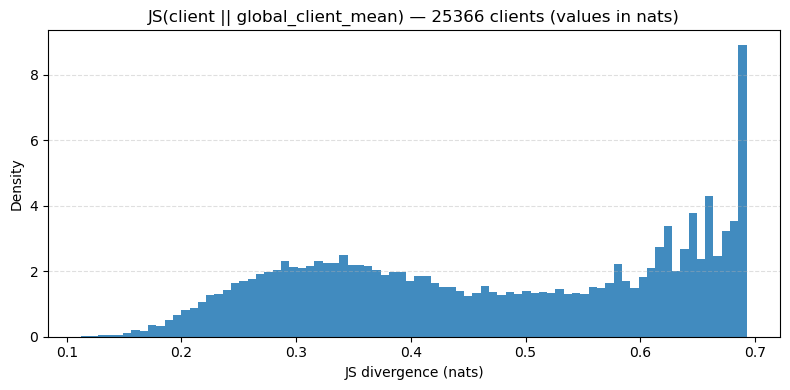

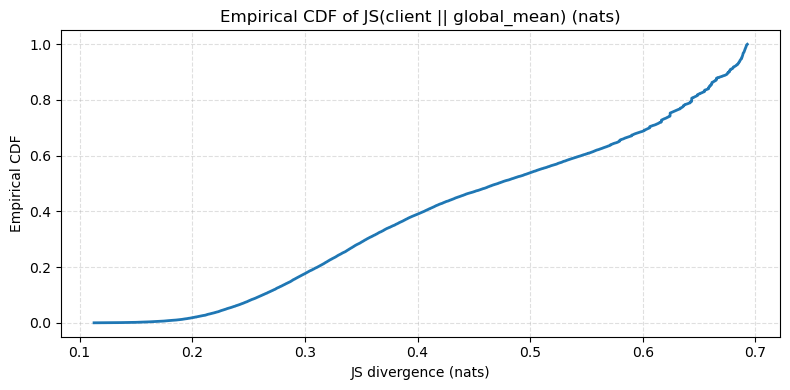


Top 10 clients (largest JS) among the selection:
  client_index=19802 (selection idx), client_id=19802, JS(nats)=0.6929
  client_index=18494 (selection idx), client_id=18494, JS(nats)=0.6928
  client_index=15384 (selection idx), client_id=15384, JS(nats)=0.6928
  client_index=19755 (selection idx), client_id=19755, JS(nats)=0.6928
  client_index=18010 (selection idx), client_id=18010, JS(nats)=0.6928
  client_index=17560 (selection idx), client_id=17560, JS(nats)=0.6928
  client_index=22218 (selection idx), client_id=22218, JS(nats)=0.6928
  client_index=16689 (selection idx), client_id=16689, JS(nats)=0.6928
  client_index=24717 (selection idx), client_id=24717, JS(nats)=0.6928
  client_index=22582 (selection idx), client_id=22582, JS(nats)=0.6928

Bottom 10 clients (smallest JS) among the selection:
  client_index=1178, client_id=1178, JS(nats)=0.1128
  client_index=1349, client_id=1349, JS(nats)=0.1153
  client_index=307, client_id=307, JS(nats)=0.1155
  client_index=911, client_id

In [51]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

# -------------------------
# Config
# -------------------------
MAPPING_DIR_OG = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping_og")
CSV_FILES = [
    MAPPING_DIR_OG / "train.csv",
    MAPPING_DIR_OG / "validation.csv",
    MAPPING_DIR_OG / "test.csv",
]
RNG_SEED = 12345
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

# If N_SELECT is None -> use ALL clients
# If N_SELECT is an integer < total clients -> randomly sample that many clients (reproducible by RNG_SEED)
# If N_SELECT >= total clients -> use all clients
N_SELECT = 100000   # <-- set this to how many clients you want to compute JS on (None or int)

# Safety: avoid accidentally huge runs; you can increase if you want
MAX_ALLOW = 100000  # allow up to this many clients for a single run (practical guard)
# -------------------------
# Helpers
# -------------------------
def js_divergence_batch(P, Q, eps=1e-12):
    """
    P: (B, L) or (L,) ; Q: (L,) or (B, L)
    Returns: (B,) JS divergences (in nats)
    """
    P = np.maximum(P, eps)
    Q = np.maximum(Q, eps)
    # Ensure shapes
    if P.ndim == 1:
        P = P[None, :]
    if Q.ndim == 1:
        Q = Q[None, :]
    M = 0.5 * (P + Q)
    klP = np.sum(P * (np.log(P) - np.log(M)), axis=1)
    klQ = np.sum(Q * (np.log(Q) - np.log(M)), axis=1)
    return 0.5 * (klP + klQ)

# -------------------------
# Load OG CSVs and build per-client label distributions
# -------------------------
start_all = time.time()
dfs = []
for p in CSV_FILES:
    if not p.exists():
        raise FileNotFoundError(f"{p} not found")
    dfs.append(pd.read_csv(p))
df = pd.concat(dfs, ignore_index=True)
print("Loaded rows:", len(df))
print("Unique clients in OG mapping:", df["client_id"].nunique())

labels = sorted(df["label_name"].unique())
lid = {l:i for i,l in enumerate(labels)}
L = len(labels)
print("Number of labels:", L)

# group counts per client x label
g = df.groupby(["client_id","label_name"]).size().reset_index(name="cnt")
clients = sorted(g["client_id"].unique())
C = len(clients)
print("Num clients considered (distinct client_ids found in OG CSVs):", C)

cid_index = {c:i for i,c in enumerate(clients)}
mat_counts = np.zeros((C, L), dtype=np.float64)
for _, row in g.iterrows():
    i = cid_index[row["client_id"]]
    j = lid[row["label_name"]]
    mat_counts[i, j] = row["cnt"]

# convert to empirical distributions (rows sum to 1)
row_sums = mat_counts.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
mat = mat_counts / row_sums   # shape (C, L)

# -------------------------
# Select subset of clients (time-aware / user-controlled)
# -------------------------
if N_SELECT is None:
    use_all = True
    n_use = C
else:
    n_use = int(N_SELECT)
    use_all = (n_use >= C)

if use_all:
    sel_idx = np.arange(C)
    n_use = C
else:
    if n_use > MAX_ALLOW:
        raise RuntimeError(f"N_SELECT={n_use} exceeds safety MAX_ALLOW={MAX_ALLOW}. Reduce N_SELECT or raise MAX_ALLOW.")
    sel_idx = np.random.choice(np.arange(C), size=n_use, replace=False)

print(f"Selected {n_use} clients for JS computation (use_all={use_all}).")

# -------------------------
# Compute global client-average distribution (mean over selected client rows)
# -------------------------
t0 = time.time()
global_mean = mat[sel_idx].mean(axis=0)   # shape (L,)
global_mean /= (global_mean.sum() + 1e-12)  # numeric safety
t1 = time.time()
print(f"Computed global client-average distribution in {t1-t0:.3f}s")

# -------------------------
# Compute JS(client || global_mean) for selected clients (JS in nats)
# -------------------------
t0 = time.time()
P = mat[sel_idx]          # (n_use, L)
Q = global_mean           # (L,)
js_vals = js_divergence_batch(P, Q)   # (n_use,)
t1 = time.time()
print(f"Computed JS for {n_use} clients in {t1-t0:.3f}s (total elapsed {time.time()-start_all:.3f}s)")

# -------------------------
# Summaries & plots (JS in nats; directly comparable to your cluster JS)
# -------------------------
print("JS stats (nats): mean={:.4f}, median={:.4f}, std={:.4f}, min={:.4f}, max={:.4f}"
      .format(js_vals.mean(), np.median(js_vals), js_vals.std(), js_vals.min(), js_vals.max()))

# Histogram
plt.figure(figsize=(8,4))
plt.hist(js_vals, bins=80, density=True, alpha=0.85)
plt.xlabel("JS divergence (nats)")
plt.ylabel("Density")
plt.title(f"JS(client || global_client_mean) — {n_use} clients (values in nats)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# CDF
plt.figure(figsize=(8,4))
xs = np.sort(js_vals)
ys = np.linspace(0,1,len(xs))
plt.plot(xs, ys, lw=2)
plt.xlabel("JS divergence (nats)")
plt.ylabel("Empirical CDF")
plt.title("Empirical CDF of JS(client || global_mean) (nats)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Top/bottom clients (by JS)
K = 10
order = np.argsort(js_vals)
bottom_k = order[:K]
top_k = order[-K:][::-1]
print(f"\nTop {K} clients (largest JS) among the selection:")
for pos in top_k:
    orig_cid = clients[int(sel_idx[pos])]
    print(f"  client_index={pos} (selection idx), client_id={orig_cid}, JS(nats)={js_vals[pos]:.4f}")

print(f"\nBottom {K} clients (smallest JS) among the selection:")
for pos in bottom_k:
    orig_cid = clients[int(sel_idx[pos])]
    print(f"  client_index={pos}, client_id={orig_cid}, JS(nats)={js_vals[pos]:.4f}")

# Quick numeric quantiles
q = [0,1,5,10,25,50,75,90,95,99,100]
qs = np.percentile(js_vals, q)
print("\nQuantiles (percentile : value in nats):")
for pct, val in zip(q, qs):
    print(f"  {pct:3d}% : {val:.4f}")

print("\nDone.")

Sampling 50 clients out of 25366 total (seed=41).


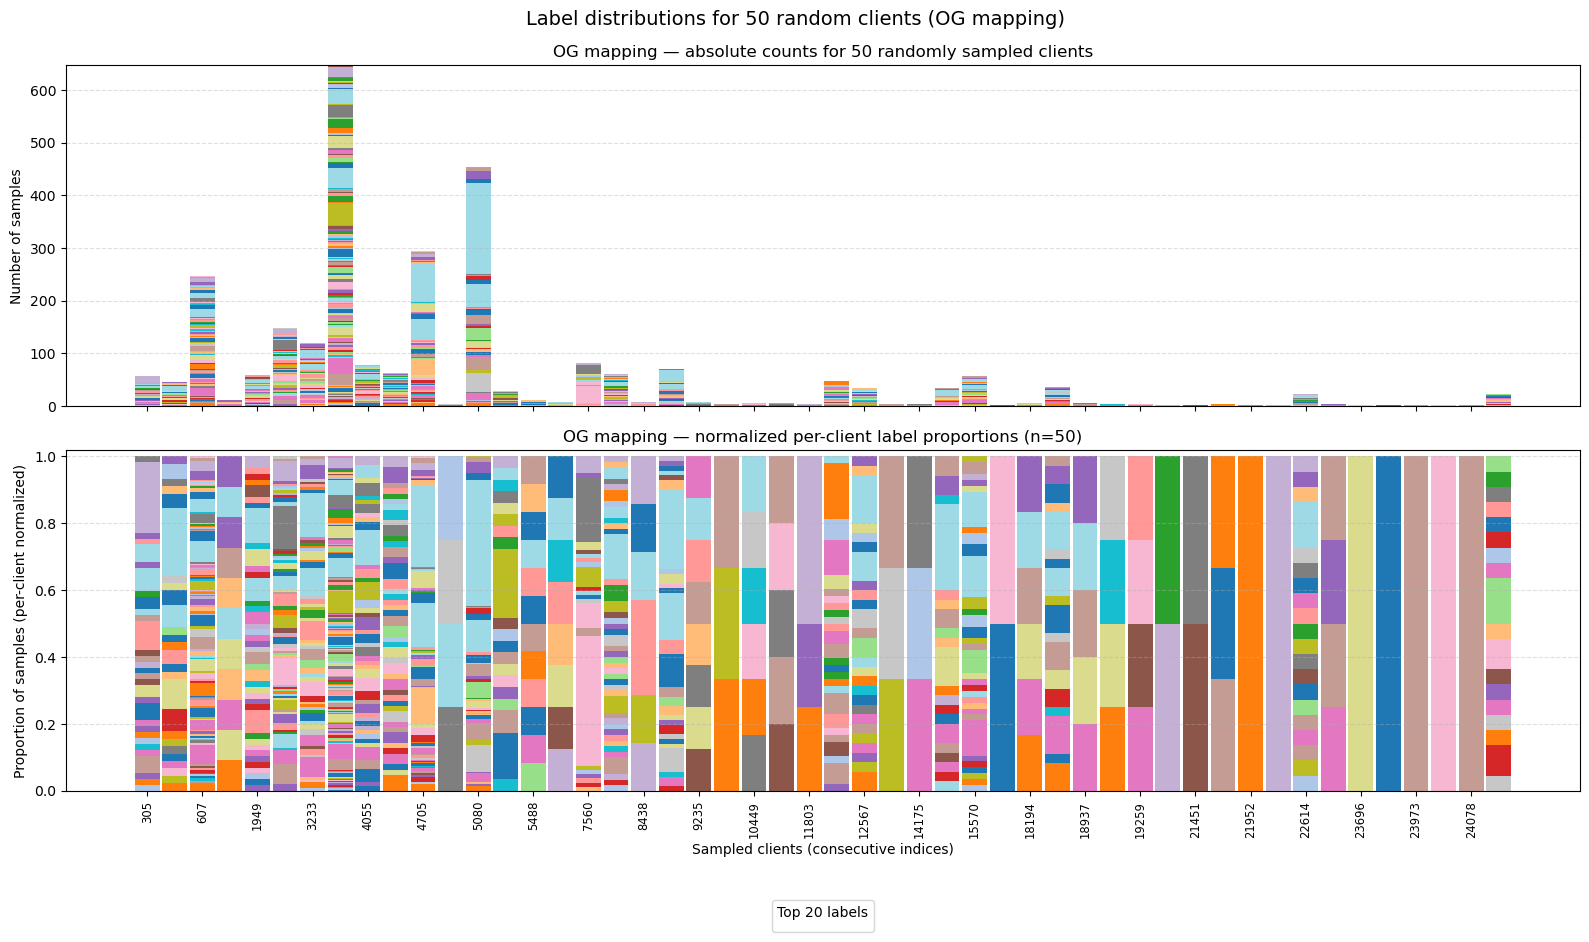

In [52]:
# Plot stacked label distributions for a random subset of clients from the OG mapping
# (absolute counts above, per-client normalized proportions below)
import random
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
RNG_SEED = 41
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

MAPPING_DIR_OG = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping_og")
CSV_FILES_OG = [
    MAPPING_DIR_OG / "train.csv",
    MAPPING_DIR_OG / "validation.csv",
    MAPPING_DIR_OG / "test.csv",
]

N_CLIENTS_TO_PLOT_LABEL_DISTRIBUTION = 50

# -----------------------------
# Load OG partition data (union of splits)
# -----------------------------
dfs = []
for p in CSV_FILES_OG:
    if not p.exists():
        raise FileNotFoundError(f"{p} not found: {p}")
    dfs.append(pd.read_csv(p, usecols=["client_id", "label_name"]))
df_all = pd.concat(dfs, ignore_index=True)

# Unique client ids in OG mapping
all_clients = sorted(df_all["client_id"].unique().astype(int).tolist())
if len(all_clients) == 0:
    raise RuntimeError("No clients found in OG mapping.")

n_pick = min(N_CLIENTS_TO_PLOT_LABEL_DISTRIBUTION, len(all_clients))
sampled_clients = sorted(random.sample(all_clients, n_pick))

print(f"Sampling {n_pick} clients out of {len(all_clients)} total (seed={RNG_SEED}).")

# -----------------------------
# Aggregate label counts for sampled clients
# -----------------------------
client_label_counts = defaultdict(Counter)
for _, row in df_all[df_all["client_id"].isin(sampled_clients)].iterrows():
    cid = int(row["client_id"])
    lab = row["label_name"]
    client_label_counts[cid][lab] += 1

# Build full label vocabulary across sampled clients (keep consistent ordering)
labels = sorted({lab for cnt in client_label_counts.values() for lab in cnt.keys()})
if len(labels) == 0:
    raise RuntimeError("No labels found for sampled clients.")

# Build DataFrame rows in the same order as sampled_clients (consecutive indices 0..n-1)
mat_abs = []
for cid in sampled_clients:
    mat_abs.append([client_label_counts[cid].get(lab, 0) for lab in labels])
mat_abs = pd.DataFrame(mat_abs, index=range(len(sampled_clients)), columns=labels)

# Normalized per-client proportions (rows sum to 1; zero-rows handled)
row_sums = mat_abs.sum(axis=1).replace(0, 1)  # avoid division by zero
mat_norm = mat_abs.div(row_sums, axis=0)

# -----------------------------
# Plot stacked charts
# -----------------------------
fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(16, 10), sharex=True,
                                     gridspec_kw={'height_ratios': [1, 1]})

# Choose colors (cycle through a qualitative palette)
cmap = plt.get_cmap("tab20")
colors = [cmap(i % cmap.N) for i in range(len(labels))]

# Top: absolute counts stacked
bottom = np.zeros(len(sampled_clients), dtype=int)
for i, lab in enumerate(labels):
    vals = mat_abs[lab].values
    ax_top.bar(mat_abs.index, vals, bottom=bottom, label=lab, width=0.9, color=colors[i])
    bottom = bottom + vals
ax_top.set_ylabel("Number of samples")
ax_top.set_title(f"OG mapping — absolute counts for {n_pick} randomly sampled clients")
ax_top.grid(axis="y", linestyle="--", alpha=0.4)

# Bottom: per-client normalized stacked
bottom = np.zeros(len(sampled_clients), dtype=float)
x = list(range(len(sampled_clients)))
for i, lab in enumerate(labels):
    vals = mat_norm[lab].values
    ax_bot.bar(x, vals, bottom=bottom, label=lab, width=0.9, color=colors[i])
    bottom = bottom + vals
ax_bot.set_xlabel("Sampled clients (consecutive indices)")
ax_bot.set_ylabel("Proportion of samples (per-client normalized)")
ax_bot.set_ylim(0, 1.02)
ax_bot.set_title(f"OG mapping — normalized per-client label proportions (n={n_pick})")
ax_bot.grid(axis="y", linestyle="--", alpha=0.4)

# Legend: if too many labels, show only top-k by total count across sampled clients
MAX_LEGEND = 20
if len(labels) <= MAX_LEGEND:
    ax_bot.legend(ncol=4, bbox_to_anchor=(0.5, -0.30), loc="upper center")
else:
    totals = mat_abs.sum(axis=0).sort_values(ascending=False)
    topk = totals.index[:MAX_LEGEND].tolist()
    # create handles/labels for topk in the same order
    handles = [plt.Rectangle((0,0),1,1, color=colors[labels.index(l)]) for l in topk]
    ax_bot.legend(handles, topk, title=f"Top {MAX_LEGEND} labels", bbox_to_anchor=(0.5, -0.30), loc="upper center")

# Improve x-axis readability: label every kth tick with the original client id
k = max(1, len(sampled_clients) // 20)  # label up to ~20 ticks
xticks = list(range(0, len(sampled_clients), k))
xtick_labels = [str(sampled_clients[i]) for i in xticks]
ax_bot.set_xticks(xticks)
ax_bot.set_xticklabels(xtick_labels, rotation=90, fontsize="small")

plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.suptitle(f"Label distributions for {n_pick} random clients (OG mapping)", fontsize=14)
plt.show()


## Utils

In [53]:
# import json
# from collections import Counter

# CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")

# with open(CLUSTERS_JSON, "r") as f:
#     clusters = json.load(f)

# all_models = []
# for c in clusters:
#     cid = c.get("id", None)
#     models = c.get("models", [])
#     for m in models:
#         all_models.append((m, cid))

# # Count model occurrences
# model_counts = Counter([m for m, _ in all_models])
# dupes = {m: count for m, count in model_counts.items() if count > 1}

# if not dupes:
#     print("✅ No duplicate model strings found in any cluster.")
# else:
#     print(f"⚠️ Found {len(dupes)} duplicate model strings across clusters.\n")
#     for m, count in dupes.items():
#         cluster_ids = [cid for mm, cid in all_models if mm == m]
#         print(f"Model '{m}' appears {count} times in clusters: {cluster_ids}")


In [54]:
# import json
# import time
# from pathlib import Path
# from collections import defaultdict, Counter

# # -------- CONFIG (you must choose) --------
# CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
# KEEP_POLICY = "first"  # <-- REQUIRED: set to one of: "first", "highest_rank", "lowest_rank", "smallest_cluster"
# DRY_RUN = False      # True -> only report; False -> write changes (with backup)

# # ------------------------------------------

# if KEEP_POLICY not in {"first", "highest_rank", "lowest_rank", "smallest_cluster"}:
#     raise ValueError("Please set KEEP_POLICY to one of: 'first', 'highest_rank', 'lowest_rank', 'smallest_cluster'.")

# # Load clusters
# with open(CLUSTERS_JSON, "r") as f:
#     clusters = json.load(f)

# # Normalize & verify structure
# for idx, c in enumerate(clusters):
#     if "id" not in c or "models" not in c:
#         raise ValueError(f"Cluster at index {idx} missing 'id' or 'models'. Entry: {c}")
#     if not isinstance(c["models"], list):
#         raise TypeError(f"Cluster id={c['id']} has non-list 'models'.")
#     if "rank" not in c:
#         # If rank is missing, treat as 0 for ranking-based policies
#         c["rank"] = 0

# # Prepare helpers
# cluster_index_by_id = {c["id"]: i for i, c in enumerate(clusters)}
# cluster_sizes = {c["id"]: len(c["models"]) for c in clusters}

# # Collect occurrences: model -> list of (cluster_id, rank, cluster_file_index, position_in_models_list)
# occ = defaultdict(list)
# for c_idx, c in enumerate(clusters):
#     cid = c["id"]
#     crank = c.get("rank", 0)
#     for pos, m in enumerate(c["models"]):
#         occ[m].append((cid, crank, c_idx, pos))

# # Determine duplicates
# dupe_models = {m: lst for m, lst in occ.items() if len(lst) > 1}
# print(f"Found {len(dupe_models)} models that appear in multiple clusters.")

# def choose_winner(model, entries):
#     """
#     entries: list of tuples (cluster_id, rank, cluster_file_index, pos_in_list)
#     Returns winning (cluster_id, rank, cluster_file_index, pos_in_list)
#     """
#     if KEEP_POLICY == "first":
#         # first by file order (cluster_file_index), then position
#         return sorted(entries, key=lambda t: (t[2], t[3]))[0]
#     elif KEEP_POLICY == "highest_rank":
#         # highest rank wins; tie-breaker: first by file order, then pos
#         return sorted(entries, key=lambda t: (-t[1], t[2], t[3]))[0]
#     elif KEEP_POLICY == "lowest_rank":
#         # lowest rank wins; tie-breaker: first by file order, then pos
#         return sorted(entries, key=lambda t: (t[1], t[2], t[3]))[0]
#     elif KEEP_POLICY == "smallest_cluster":
#         # smallest cluster size wins; tie-breakers: first by file order, then pos
#         return sorted(entries, key=lambda t: (cluster_sizes.get(t[0], 10**9), t[2], t[3]))[0]
#     else:
#         raise RuntimeError("Unreachable: invalid KEEP_POLICY")

# # Compute removals
# removals = defaultdict(list)  # cluster_id -> list of models to remove
# kept = {}                     # model -> cluster_id
# for m, entries in dupe_models.items():
#     win = choose_winner(m, entries)
#     win_cid = win[0]
#     kept[m] = win_cid
#     for (cid, _, _, _) in entries:
#         if cid != win_cid:
#             removals[cid].append(m)

# # Report plan
# total_removals = sum(len(v) for v in removals.values())
# print(f"\nPlanned removals: {total_removals} duplicate occurrences across {len([k for k,v in removals.items() if v])} clusters.")
# preview_limit = 10
# shown = 0
# for cid, mods in removals.items():
#     if not mods:
#         continue
#     to_show = mods[:max(0, preview_limit - shown)]
#     if to_show:
#         print(f" - Cluster {cid}: remove {len(mods)} models (showing {len(to_show)}): {to_show}")
#         shown += len(to_show)
#     if shown >= preview_limit:
#         break

# # Apply (if not dry run)
# if not DRY_RUN and total_removals > 0:
#     # Create backup
#     ts = time.strftime("%Y%m%d-%H%M%S")
#     backup_path = CLUSTERS_JSON.with_suffix(f".backup.{ts}.json")
#     with open(backup_path, "w") as bf:
#         json.dump(clusters, bf, indent=2, ensure_ascii=False)
#     print(f"\nBackup created at: {backup_path}")

#     # Build new clusters with removals applied
#     cid_to_idx = {c["id"]: i for i, c in enumerate(clusters)}
#     for cid, mods in removals.items():
#         cidx = cid_to_idx[cid]
#         before = len(clusters[cidx]["models"])
#         # Remove while preserving order
#         mods_set = set(mods)
#         clusters[cidx]["models"] = [m for m in clusters[cidx]["models"] if m not in mods_set]
#         after = len(clusters[cidx]["models"])
#         assert after <= before
#         cluster_sizes[cid] = after

#     # Save back in place
#     with open(CLUSTERS_JSON, "w") as f:
#         json.dump(clusters, f, indent=2, ensure_ascii=False)
#     print(f"✅ clusters.json updated in place. Removed {total_removals} duplicate occurrences.")

# elif DRY_RUN:
#     print("\n(DRY_RUN=True) No changes written. Set DRY_RUN=False to apply.")
# else:
#     print("\nNo duplicates to remove. File left unchanged.")

In [55]:
# import pickle
# from pathlib import Path

# CLIENTS_PKL = Path("../benchmark/dataset/data/clients.pkl")

# with open(CLIENTS_PKL, "rb") as f:
#     clients_obj = pickle.load(f)

# # Extract ids depending on structure
# ids = []
# if isinstance(clients_obj, dict):
#     for v in clients_obj.values():
#         if "id" not in v:
#             raise RuntimeError("Missing 'id' field in a client entry.")
#         ids.append(int(v["id"]))
# elif isinstance(clients_obj, (list, tuple)):
#     for v in clients_obj:
#         ids.append(int(v["id"]))
# else:
#     raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")

# ids = sorted(ids)
# n = len(ids)

# print(f"Loaded {n} client entries.")
# print(f"Min id = {ids[0]}, Max id = {ids[-1]}")

# expected = list(range(ids[0], ids[-1] + 1))
# if ids == expected:
#     print("✅ IDs are contiguous with no duplicates.")
# else:
#     missing = sorted(set(expected) - set(ids))
#     duplicates = [x for x in ids if ids.count(x) > 1]
#     print("❌ IDs are not contiguous or contain duplicates.")
#     if missing:
#         print(f"  Missing {len(missing)} ids, first few: {missing[:20]}")
#     if duplicates:
#         print(f"  Duplicate ids found: {set(duplicates)}")


In [56]:
# import pickle, time
# from pathlib import Path

# CLIENTS_PKL = Path("../benchmark/dataset/data/clients.pkl")

# # 1) Load
# with open(CLIENTS_PKL, "rb") as f:
#     clients_obj = pickle.load(f)

# # 2) Shift IDs
# def shift_id(obj):
#     if isinstance(obj, dict):
#         for v in obj.values():
#             if "id" not in v:
#                 raise RuntimeError("Missing 'id' field in a client entry.")
#             v["id"] = int(v["id"]) - 1
#     elif isinstance(obj, (list, tuple)):
#         for v in obj:
#             v["id"] = int(v["id"]) - 1
#     else:
#         raise TypeError(f"Unsupported clients.pkl type: {type(obj)}")
#     return obj

# clients_obj = shift_id(clients_obj)

# # 3) Verify contiguous 0..12640 with no duplicates
# ids = []
# if isinstance(clients_obj, dict):
#     ids = [int(v["id"]) for v in clients_obj.values()]
# else:
#     ids = [int(v["id"]) for v in clients_obj]

# ids_sorted = sorted(ids)
# expected = list(range(0, 12641))  # 0..12640 inclusive

# if ids_sorted != expected:
#     raise RuntimeError("After shifting, IDs are not contiguous 0..12640.")

# print("✅ Verified: IDs now span 0..12640 with no duplicates.")

# # 4) Backup original
# ts = time.strftime("%Y%m%d-%H%M%S")
# backup_path = CLIENTS_PKL.with_suffix(f".backup.{ts}.pkl")
# with open(backup_path, "wb") as f:
#     pickle.dump(clients_obj, f)
# print(f"Backup of modified object written to: {backup_path}")

# # 5) Overwrite original file
# with open(CLIENTS_PKL, "wb") as f:
#     pickle.dump(clients_obj, f)
# print(f"✅ Overwrote {CLIENTS_PKL} with shifted IDs.")


In [4]:
# Remap client_id to [0..11324] with modulo wrap for any base-id >= 11325
# Deterministic base mapping: ascending order of original client_id (union across train/test/validation)
import pandas as pd
from pathlib import Path
from collections import defaultdict

# === CONFIG ===
DATA_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping_og")
INPUT_FILES = ["train.csv", "test.csv", "validation.csv"]
OUTPUT_SUFFIX = "_remapped.csv"

# Fixed target size
TARGET_N = 11325   # final IDs must lie in [0..11324]

REQUIRED_COLUMNS = {"client_id", "sample_path", "label_name", "label_id"}

# === Load ===
dfs = {}
for fname in INPUT_FILES:
    fpath = DATA_DIR / fname
    if not fpath.exists():
        raise FileNotFoundError(f"Missing file: {fpath}")
    df = pd.read_csv(fpath)
    missing = REQUIRED_COLUMNS - set(df.columns)
    if missing:
        raise ValueError(f"{fname} is missing required columns: {sorted(missing)}")
    try:
        df["client_id"] = df["client_id"].astype(int)
    except Exception as e:
        raise ValueError(f"{fname}: 'client_id' must be integers. Underlying error: {e}")
    try:
        df["label_id"] = df["label_id"].astype(int)
    except Exception as e:
        raise ValueError(f"{fname}: 'label_id' must be integers. Underlying error: {e}")
    dfs[fname] = df

# === Build global base mapping (union across all files, ascending) ===
all_ids = pd.Index([])
for df in dfs.values():
    all_ids = all_ids.union(df["client_id"].unique())

all_ids = pd.Index(sorted(all_ids))
n_unique = len(all_ids)

# Base (pre-modulo) mapping: old -> base_new_id (0..n_unique-1)
base_mapping = {old_id: new_id for new_id, old_id in enumerate(all_ids)}

# Final mapping with modulo for base ids >= TARGET_N
def final_id_from_base(bid: int) -> int:
    return bid if bid < TARGET_N else (bid % TARGET_N)

final_mapping = {old: final_id_from_base(bid) for old, bid in base_mapping.items()}

# === Sanity: confirm that (a) train clients get base ids < TARGET_N (informative only)
train_ids = set(dfs["train.csv"]["client_id"].unique())
max_base_train = max(base_mapping[oid] for oid in train_ids)
train_with_wrapped = sum(1 for oid in train_ids if base_mapping[oid] >= TARGET_N)
# Not failing on this—just reporting:
if train_with_wrapped > 0:
    print(f"Note: {train_with_wrapped} train clients would have wrapped (base id >= {TARGET_N}).")
else:
    print("Train set clients all have base ids < TARGET_N (as expected).")

# === Collision analysis (many-to-one after modulo)
inverse = defaultdict(list)   # final_new_id -> [old_client_ids...]
for old, fid in final_mapping.items():
    inverse[fid].append(old)

collision_rows = []
collision_count = 0
max_bucket = 0
for fid, olds in inverse.items():
    sz = len(olds)
    max_bucket = max(max_bucket, sz)
    if sz > 1:
        collision_count += 1
        # Collect a short sample (up to 10) to keep CSV readable
        sample_olds = olds[:10]
        collision_rows.append({
            "final_new_client_id": fid,
            "num_old_client_ids": sz,
            "sample_old_client_ids": sample_olds
        })

# Save detailed collision report
collision_df = pd.DataFrame(collision_rows).sort_values(
    by=["num_old_client_ids", "final_new_client_id"], ascending=[False, True]
)
collision_report_path = DATA_DIR / "client_id_collisions.csv"
collision_df.to_csv(collision_report_path, index=False)

# Save complete mapping (old, base, final)
mapping_df = pd.DataFrame({
    "old_client_id": all_ids,
    "base_new_id": [base_mapping[oid] for oid in all_ids],
    "final_new_id": [final_mapping[oid] for oid in all_ids],
})
mapping_path = DATA_DIR / "client_id_mapping_mod11325.csv"
mapping_df.to_csv(mapping_path, index=False)

# === Apply final mapping consistently across splits
remapped_dfs = {}
for fname, df in dfs.items():
    df2 = df.copy()
    df2["client_id"] = df2["client_id"].map(final_mapping)
    if df2["client_id"].isna().any():
        missing_vals = df.loc[df2["client_id"].isna(), "client_id"].unique()
        raise ValueError(f"{fname}: unmapped client_id values detected: {missing_vals[:10]} ...")
    df2["client_id"] = df2["client_id"].astype(int)
    remapped_dfs[fname] = df2

# === Save non-destructively
for fname, df2 in remapped_dfs.items():
    out_path = DATA_DIR / fname.replace(".csv", OUTPUT_SUFFIX)
    df2.to_csv(out_path, index=False)

# === Report ===
print("✔ Remapping complete with modulo wrapping.")
print(f"Total unique old client IDs (union): {n_unique}")
print(f"Final ID space: 0..{TARGET_N - 1} (modulo {TARGET_N})")
print(f"Final IDs that have collisions (≥2 old IDs mapped to same final id): {collision_count}")
print(f"Largest number of old IDs sharing a single final id: {max_bucket}")
for fname in INPUT_FILES:
    before_n = dfs[fname]["client_id"].nunique()
    after_n = remapped_dfs[fname]["client_id"].nunique()
    print(f"- {fname}: unique clients before={before_n}, after={after_n}")

print(f"Mapping file: {mapping_path}")
print(f"Collision report: {collision_report_path}")

Note: 3980 train clients would have wrapped (base id >= 11325).
✔ Remapping complete with modulo wrapping.
Total unique old client IDs (union): 25366
Final ID space: 0..11324 (modulo 11325)
Final IDs that have collisions (≥2 old IDs mapped to same final id): 11325
Largest number of old IDs sharing a single final id: 3
- train.csv: unique clients before=11325, after=8446
- test.csv: unique clients before=24870, after=11325
- validation.csv: unique clients before=13215, after=11325
Mapping file: /Data/baptiste.geisenberger/Data/openImg/client_data_mapping_og/client_id_mapping_mod11325.csv
Collision report: /Data/baptiste.geisenberger/Data/openImg/client_data_mapping_og/client_id_collisions.csv
